# Evaluation of GRN inference methods
## Explanatory analysis
### by Jalil Nourisa



# Imports

In [40]:
%reload_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tqdm
import json
import warnings
import matplotlib
import sys
import requests
import seaborn as sns
from scipy.stats import spearmanr
import gseapy as gp
import scanpy as sc 
from scipy.sparse import csr_matrix



# from mplfonts import use_font

sys.path.append('../../')
from grn_benchmark.src.helper import surragate_names
from task_grn_inference.src.utils.util import colors_blind
from task_grn_inference.src.exp_analysis.helper import *


controls3 = ['Dabrafenib', 'Belinostat', 'Dimethyl Sulfoxide']

task_grn_inference_dir = '../../task_grn_inference'
results_folder = '../results_folder/'
perturb_col = 'perturbation'

plt.rcParams['font.family'] = 'Liberation Sans'
default_font = matplotlib.rcParams['font.family']
print(default_font)

def binarize_weight(weight):
    if weight > 0:
        return 1
    elif weight < 0:
        return -1
    else:
        return 0
datasets = ['op', 'replogle2', 'nakatake', 'norman', 'adamson']

all_models = ['negative_control', 'positive_control', 'pearson_corr', 'ppcor', 'portia', 'grnboost2', 'scenic', 'scglue', 'celloracle', 'figr', 'granie', 'scenicplus']
all_models = [surragate_names.get(name,name) for name in all_models]
color_map_methods = {key:color for key, color in zip(all_models, sns.color_palette('Set2', len(all_models)))}

# Assign each method a different linestyle
import itertools
line_styles = ['-', '--', '-.', ':']
linestyle_map_methods = {key: linestyle for key, linestyle in zip(all_models, itertools.cycle(line_styles))}


%matplotlib inline

['Liberation Sans']


In [41]:
# panglao_df = pd.read_csv('../output/PanglaoDB_markers_27_Mar_2020.tsv.gz', sep='\t')
# panglao_df = panglao_df[panglao_df.species.isin(['Mm Hs','Hs'])]
# panglao_df['cell type'].nunique()

# Dataset overview

In [42]:
for dataset in datasets: 
    print(f'----inference {dataset}---')
    inference_dataset = ad.read_h5ad(f'{task_grn_inference_dir}/resources/inference_datasets/{dataset}_rna.h5ad')
    print('sample count: ', len(inference_dataset),'gene count: ', inference_dataset.var_names.nunique())
    if 'perturbation' in inference_dataset.obs:
        print('pertub count: ', inference_dataset.obs['perturbation'].nunique())

    print(f'----evaluation {dataset}---')
    perturbation_data = ad.read_h5ad(f'{task_grn_inference_dir}/resources/evaluation_datasets/{dataset}_perturbation.h5ad')
    print('sample count: ', len(perturbation_data),'gene count: ', perturbation_data.var_names.nunique(), 'pertub count: ', perturbation_data.obs['perturbation'].nunique())

----inference op---


sample count:  25551 gene count:  22787
----evaluation op---
sample count:  2170 gene count:  15215 pertub count:  138
----inference replogle2---
sample count:  8869 gene count:  8244
pertub count:  7880
----evaluation replogle2---
sample count:  2072 gene count:  8244 pertub count:  2049
----inference nakatake---
sample count:  454 gene count:  25090
pertub count:  231
----evaluation nakatake---
sample count:  456 gene count:  25090 pertub count:  232
----inference norman---
sample count:  44710 gene count:  5045
pertub count:  116
----evaluation norman---
sample count:  115 gene count:  5035 pertub count:  115
----inference adamson---
sample count:  32223 gene count:  5060
pertub count:  17
----evaluation adamson---
sample count:  65 gene count:  5060 pertub count:  65


In [43]:
# - perturbation strength 
def determine_fold_change_effect(adata, layer = 'X_norm'):
    results = []

    obs_all = adata.obs.reset_index(drop=True)
    X_all = adata.layers[layer]

    if 'cell_type' not in obs_all:
        obs_all['cell_type'] = 'celltype'
        
    for cell_type in obs_all.cell_type.unique():
        mask_celltype = obs_all.cell_type == cell_type

        obs = obs_all.loc[mask_celltype, :]
        X = X_all[mask_celltype, :]


        # - Compute absolute fold change for each gene compared to control group
        # control_indices = obs.index[obs['is_control']].tolist()
        control_matrix = X[obs['is_control'], :]
        control_mean_expression = np.mean(control_matrix, axis=0)
        control_std_expression = np.std(control_matrix, axis=1).mean()
        
        # - Group by unique perturbation samples
        for perturbation in obs['perturbation'].unique():
            group_indices = obs['perturbation']==perturbation
            sample_matrix = X[group_indices, :]  # Subset the gene expression data
            mean_expression = np.mean(sample_matrix, axis=0)  # Mean expression per gene for this sample
            std_expression = np.std(sample_matrix, axis=1).mean()  # Mean expression per gene for this sample
            # - calculate fold change
            mask = control_mean_expression != 0
            fold_change = (mean_expression[mask])/(control_mean_expression[mask])

            # - calulcate std 
            std_change = (std_expression)/(control_std_expression)

            # Store the results for each perturbation
            results.append({'perturbation': perturbation, 'Expression fold change': np.abs(fold_change).mean(), 'STD fold change': std_change, 'cell_type':cell_type})

    results = pd.DataFrame(results)

    return results
perturbation_dict = {}
for i, dataset in enumerate(datasets): 
    adata = ad.read_h5ad(f'{task_grn_inference_dir}/resources/datasets_raw/{dataset}_bulked.h5ad')
    print(dataset, ' number of perrutbation: ', adata.obs['perturbation'].nunique())
    perturbation_dict[dataset] = adata
    # - determine effect size
    perturb_effect_df = determine_fold_change_effect(adata)
    perturb_effect_df['Dataset'] = dataset
    perturb_effect_df['pertub_effect'] = round(np.std(adata.layers['X_norm'], axis=0).mean()/np.std(adata.layers['X_norm'], axis=1).mean(), 2)
    if i == 0:
        perturb_effect_all = perturb_effect_df
    else:
        perturb_effect_all = pd.concat([perturb_effect_all, perturb_effect_df], axis=0)
perturb_effect_all.to_csv('../results_folder/perturb_effect_all.csv')


op  number of perrutbation:  138


/home/jnourisa/miniconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


replogle2  number of perrutbation:  9722
nakatake  number of perrutbation:  463
norman  number of perrutbation:  231
adamson  number of perrutbation:  82


In [44]:
perturb_effect_all['Dataset'] = perturb_effect_all['Dataset'].map(lambda name: surragate_names.get(name,name))
# - set perturbation type 
perturb_effect_all['Perturbation type'] = perturb_effect_all['Dataset'].map({'OPSCA':'Chemical', 'Nakatake': 'Overexpression', 'Norman': 'Activation', 'Adamson':'KD', 'Replogle': 'KD'})

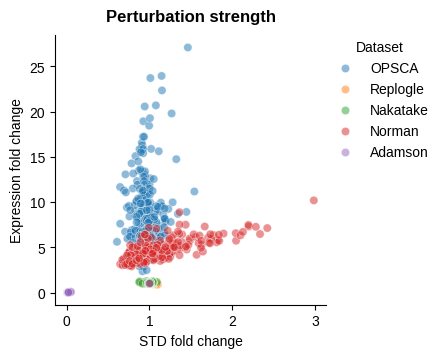

In [45]:
# - perturbation effect 

fig, ax = plt.subplots(1, 1, figsize=(3.5 , 3.5))
def plot_perturbation_strength_datasets(perturb_effect_all, ax):
    sns.scatterplot(perturb_effect_all, x='STD fold change', y='Expression fold change', hue='Dataset', alpha=.5, ax=ax)
    legend = ax.legend(bbox_to_anchor=(1.4, 1), loc='upper right', borderaxespad=0, frameon=False)
    legend.set_title("Dataset") 
    for side in ['right', 'top']:
        ax.spines[side].set_visible(False)
    ax.set_title(f"Perturbation strength", pad=10, fontsize=12, fontweight='bold')
plot_perturbation_strength_datasets(perturb_effect_all, ax)
# fig.savefig(f"{results_folder}/explanatory_analysis/figs/perturbation_strength_datasets.png", dpi=300, transparent=True, bbox_inches='tight')

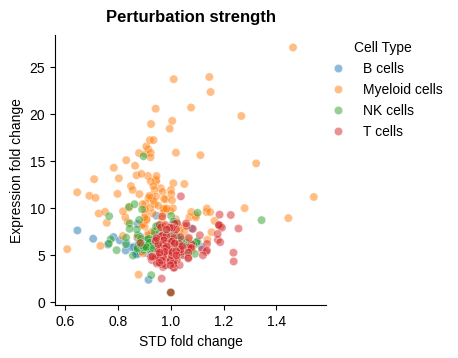

In [46]:
# - perturbation effect 
fig, ax = plt.subplots(1, 1, figsize=(3.5,3.5))
def plot_perturbation_strength_celltypes(perturb_effect_all, ax):
    sns.scatterplot(perturb_effect_all[perturb_effect_all['Dataset']=='OPSCA'], x='STD fold change', y='Expression fold change', hue='cell_type', alpha=.5, ax=ax)
    legend = ax.legend(bbox_to_anchor=(1.45, 1), loc='upper right', borderaxespad=0, frameon=False)
    legend.set_title("Cell Type") 
    for side in ['right', 'top']:
        ax.spines[side].set_visible(False)
    ax.set_title(f"Perturbation strength", pad=10, fontsize=12, fontweight='bold')
plot_perturbation_strength_celltypes(perturb_effect_all, ax)
fig.savefig(f"{results_folder}/explanatory_analysis/figs/perturbation_strength_celltypes.png", dpi=300, transparent=True, bbox_inches='tight')

In [47]:
if False:
    def plot_pertub_effect(adata, layer=None, ax=None, title=''):
        if layer is not None:
            adata.X = adata.layers[layer]
        try:
            y_true = adata.X.todense().A
        except:
            y_true = adata.X
        pertub_effect = round(np.std(y_true, axis=0).mean()/np.std(y_true, axis=1).mean(), 2)

        plot_cumulative_density(np.std(y_true, axis=0), ax=ax, label='std between samples', x_label='std')
        plot_cumulative_density(np.std(y_true, axis=1), ax=ax, label='std within samples',x_label='std')
        ax.set_title(f'{title}, pertub_effect= {pertub_effect:.2f}')

    fig, axes = plt.subplots(1, len(datasets), figsize=(4*len(datasets),3))
    for i, dataset in enumerate(datasets): 
        layer = 'X_norm'

        ax = axes[i]
        plot_pertub_effect(perturbation_dict[dataset], layer, ax, dataset)
    plt.legend()

# Format GRN models

In [48]:
if False: # granie extended grn
    net = pd.read_csv(f'{task_grn_inference_dir}/resources/grn_models/peak_gene/granie_extended.csv')
    net = net[['peak', 'gene']].drop_duplicates().reset_index(drop=True)
    net.columns = ['peak','target']
    net.to_csv(f'{task_grn_inference_dir}/resources/grn_models/peak_gene/granie.csv')
if False:  # scenicplus extended grn
    net = pd.read_csv(f'{task_grn_inference_dir}/output/scenicplus/grn_extended.csv', index_col=0)
    net = net[['peak', 'target']].drop_duplicates().reset_index(drop=True)
    net.to_csv(f'{task_grn_inference_dir}/resources/grn_models/peak_gene/scenicplus.csv')
if False: # figr extended grn
    net = pd.read_csv(f'{task_grn_inference_dir}/output/figr/cisCorr.csv', index_col=0)
    net = net[['PeakRanges', 'Gene']].drop_duplicates().reset_index(drop=True)
    net.columns = ['peak','target']
    net.to_csv(f'{task_grn_inference_dir}/resources/grn_models/peak_gene/figr.csv')

# Regression 2: consensus n regulators

In [102]:

def load_data(dataset, input_dir):
    """
    Load the JSON file for a given dataset and extract the data.
    """
    file_path = os.path.join(input_dir, 'resources/prior', f'{dataset}_consensus-num-regulators.json')
    with open(file_path, 'r') as f:
        data = json.load(f)
    gene_names = np.asarray(list(data.keys()), dtype=object)
    return data, gene_names

def process_features(data, gene_names, thetas):
    """
    Extract the number of features (regulators) for each theta value.
    """
    n_features = {
        theta: np.asarray([data[gene_name][theta] for gene_name in gene_names], dtype=int)
        for theta in thetas
    }
    return n_features

def plot_consensus_number_of_regulators(dataset, axes,thetas=['0', '0.5', '1']):
    """
    Create a plot for the consensus number of regulators for a dataset.
    """
    # Load and process data
    data, gene_names = load_data(dataset, task_grn_inference_dir)
    n_features = process_features(data, gene_names, thetas)
    
    
    for i, theta in enumerate(thetas):
        ax = axes[i]
        sns.histplot(
            data=n_features[theta], 
            ax=ax, 
            discrete=True, 
            color='#56B4E9', 
            linewidth=.5, 
            edgecolor=None
        )
        ax.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='blue')
        for side in ['right', 'top']:
            ax.spines[side].set_visible(False)
        ax.set_yscale('log')
        ax.set_ylabel('Number of target genes')
        ax.set_title(fr'$\theta$ = {theta}')
        ax.set_xlabel(r'Number of regulators')

    fig.suptitle(
        f'Consensus number of regulators ({surragate_names[dataset]})', 
        y=1.1, 
        fontsize=12, 
        fontweight='bold'
    )
    # output_path = os.path.join(output_dir, f"consensus_{dataset}.png")
    # fig.savefig(output_path, dpi=300, transparent=True, bbox_inches='tight')

def extract_nregulators_func(datasets, task_grn_inference_dir, results_folder, surrogate_names, thetas=['0', '0.5', '1']):
    """
    Analyze and plot the consensus number of regulators for a list of datasets.
    """
    n_genes_with_regulators_dict = {}

    for dataset in datasets:
        n_genes_with_regulators_dict[dataset] = []
        # Load and process data
        data, gene_names = load_data(dataset, task_grn_inference_dir)
        n_features = process_features(data, gene_names, thetas)

        # Calculate number of genes with at least one regulator for each theta
        for theta in thetas:
            n_genes_with_regulators_dict[dataset].append((n_features[theta] != 0).sum())


    return n_genes_with_regulators_dict


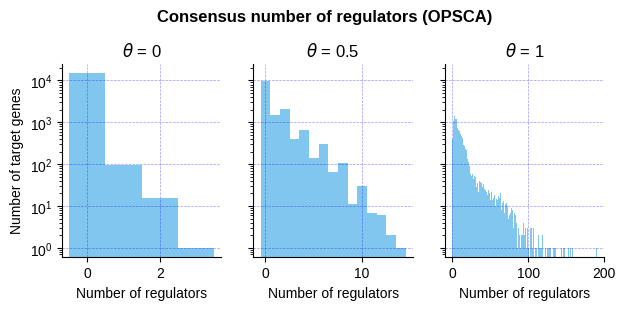

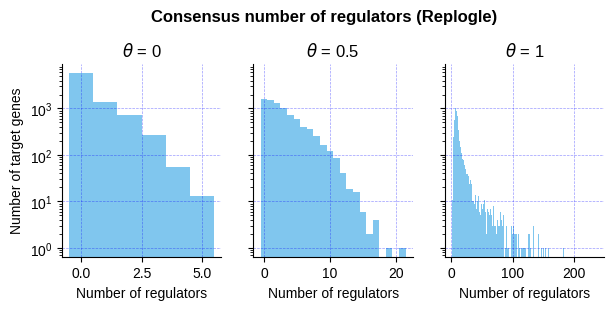

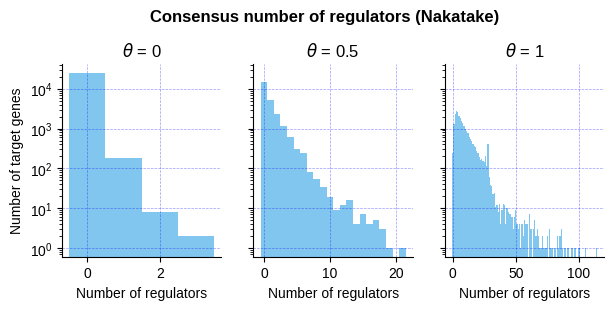

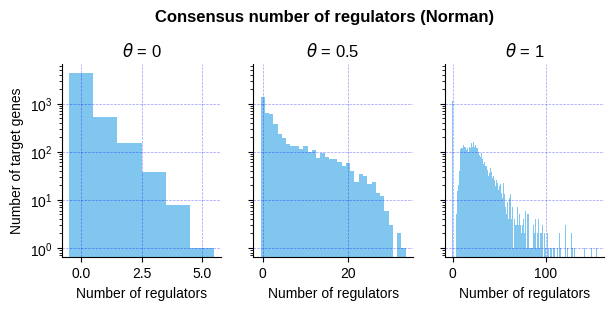

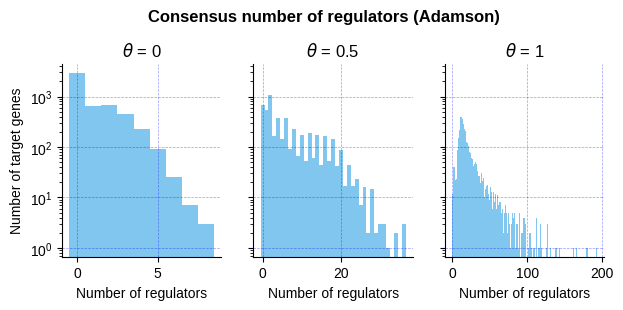

In [50]:
for dataset in datasets:
    fig, axes = plt.subplots(1, 3, figsize=(7, 2.5), sharey=True)

    plot_consensus_number_of_regulators(
        dataset=dataset, axes
    )
    plt.show()

In [51]:
n_genes_with_regulators_dict = extract_nregulators_func(
    datasets=datasets,
    task_grn_inference_dir=task_grn_inference_dir,
    results_folder=results_folder,
    surrogate_names=surragate_names
)

/vol/tmp/users/jnourisa/ipykernel_3482998/968927825.py:11: UserWarning: The palette list has more values (7) than needed (3), which may not be intended.
  sns.barplot(df, x='dataset', y='value', hue='index', palette=colors_blind)


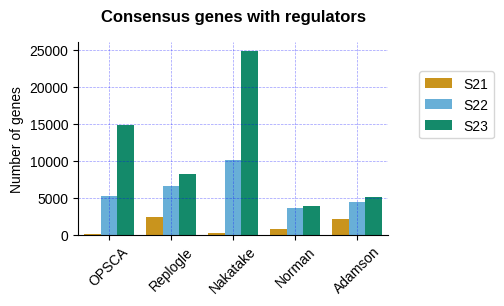

In [52]:
# Number of genes with actual regulators 
fig, ax = plt.subplots(1,1, figsize=(4, 2.5), sharey=True)
def plot_n_genes_with_regulators(n_genes_with_regulators_dict, ax):
    df = pd.DataFrame(n_genes_with_regulators_dict)
    df.index = ['static-theta-0.0', 'static-theta-0.5', 'static-theta-1.0']
    df.index = df.index.map(surragate_names)
    df.columns = df.columns.map(surragate_names)

    df = df.reset_index().melt(id_vars = 'index', var_name='dataset')
    df.index.name = 'Metric'
    sns.barplot(df, x='dataset', y='value', hue='index', palette=colors_blind)
    ax.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='blue')
    for side in ['right', 'top']:
        ax.spines[side].set_visible(False)
    # ax.set_yscale('log')
    # ax.set_xlabel(r'Number of selected regulators')
    ax.set_ylabel('Number of genes')
    ax.set_xlabel(r'')
    plt.title('Consensus genes with regulators', fontsize=12, fontweight='bold', pad=15)
    plt.legend(loc=(1.1, .5))
    plt.xticks(rotation=45)
plot_n_genes_with_regulators(n_genes_with_regulators_dict, ax)
fig.savefig(f"{results_folder}/explanatory_analysis/figs/consensus_all.png", dpi=300, transparent=True, bbox_inches='tight')


# Enrichment analysis on common TFs


In [53]:
# - reformat the genesets database
if False:
    panglao_df = pd.read_csv('../output/PanglaoDB_markers_27_Mar_2020.tsv.gz', sep='\t')

    panglao_df = panglao_df[panglao_df.species.isin(['Mm Hs','Hs'])]

    # Open a new file to write the GMT formatted data
    with open("../output/panglaodb_marker_sets.gmt", "w") as gmt_file:
        # Loop through each unique cell type in PanglaoDB
        for cell_type in panglao_df['cell type'].unique():
            # Filter genes for the current cell type
            genes = panglao_df[panglao_df['cell type'] == cell_type]['official gene symbol'].tolist()
            
            # Write the cell type name, description, and genes to the GMT file
            gmt_file.write(f"{cell_type}\tPanglaoDB cell type marker\t" + "\t".join(genes) + "\n")


In [54]:
if False:
    par = {
        'best_performers': ['pearson_corr', 'grnboost2', 'scenicplus'],
        'worse_performers': ['granie', 'ppcor', 'figr'],
        'grn_models_dir': f'{task_grn_inference_dir}/resources/grn_models/op/'

    }
    exp_objs_dict = {}

    for model in par_reg1['best_performers']+par_reg2['worse_performers']:
        par_reg1['grn_model'] = f"{par_reg1['grn_models_dir']}/{model}.csv"
        if not os.path.exists(par_reg1['grn_model']):
            print(model, ' is skipped')
            continue
        net = pd.read_csv(par_reg1['grn_model'])

        print(model, len(net))
        obj = Exp_analysis(net)
        obj.calculate_basic_stats()
        exp_objs_dict[model] = obj


    interaction_info = create_interaction_info(exp_objs_dict)
# fig = plot_interactions(interaction_info['target'], min_subset_size = 1, min_degree=2, color_map=None) 

In [55]:
if False: # enrichment analysis
    for group in [par_reg1['best_performers'], par_reg1['worse_performers']]:
        common_tfs = interaction_info['source'][group]
        common_tfs = list(common_tfs[common_tfs.all(axis=1)].index)
        print('common_tfs: ',len(common_tfs))

        # Perform Over-Representation Analysis (ORA)
        enr = gp.enrichr(
            gene_list=common_tfs,     # List of genes
            gene_sets='../output/panglaodb_marker_sets.gmt',  #KEGG_2021_Human 'GO_Biological_Process_2021'
            organism='Human',         # Organism
            outdir='output/enrichr_results', # Output directory
        )

        enrich_rr = enr.results

        enrich_rr = enrich_rr[enrich_rr['Adjusted P-value']<0.05][['Term', 'Overlap', 'Adjusted P-value', 'Genes']]
        print(enrich_rr)

        def plot_enrichment(df):
            # Calculate -log10 of Adjusted P-value for a clearer visualization
            df['-log10(Adjusted P-value)'] = -np.log10(df['Adjusted P-value'])

            # Sort the DataFrame by significance (optional)
            df = df.sort_values(by='-log10(Adjusted P-value)', ascending=False)

            # Plotting the enrichment analysis
            plt.figure(figsize=(8, 6))
            sns.barplot(data=df, y='Term', x='-log10(Adjusted P-value)', palette="viridis")

            # Add plot labels and title
            plt.xlabel("-log10(Adjusted P-value)")
            plt.ylabel("Cell Types")
            plt.title("Enrichment Analysis Results")
            plt.tight_layout()
        plot_enrichment(enrich_rr)
        plt.show()

# Stability analysis: Regression 1

## Regression 1

In [106]:
dataset = 'op' #'nakatake' #op', norman


par_reg1 = {
    'grn_models': ['pearson_corr', 'granie', 'grnboost2', 'scenicplus'],
    'enrichment_models': ['pearson_corr', 'grnboost2', 'scenicplus'],
    # 'grn_models': ['pearson_corr', 'positive_control', 'scenic', 'grnboost2'],
    # 'datasetment_models': ['pearson_corr', 'positive_control', 'grnboost2'],
    'grn_models_dir': f'{task_grn_inference_dir}/resources/grn_models/{dataset}/',
    'evaluation_data': f'{task_grn_inference_dir}/resources/evaluation_datasets/{dataset}_perturbation.h5ad',
    'layer': 'X_norm',
    'consensus':  f'../output/{dataset}_consensus-num-regulators.json',
    'tf_all': f'{task_grn_inference_dir}/resources/prior/tf_all.csv',
    'static_only': False,
    'num_workers': 4,
    'apply_tf': True,
    'apply_skeleton': False,
    'verbose': 2,
    'max_n_links': 50_000
}

exp_objs_dict = {}

for model in par_reg1['grn_models']:
    par_reg1['grn_model'] = f"{par_reg1['grn_models_dir']}/{model}.csv"
    if not os.path.exists(par_reg1['grn_model']):
        print(model, ' is skipped')
        continue
    net = pd.read_csv(par_reg1['grn_model'])

    print(model, len(net))
    obj = Exp_analysis(net)
    obj.calculate_basic_stats()
    exp_objs_dict[model] = obj


interaction_info = create_interaction_info(exp_objs_dict)
# fig = plot_interactions(interaction_info['target'], min_subset_size = 1, min_degree=1, color_map=None) 

negative_control 50000
positive_control 50000
pearson_corr 50000
ppcor 50000
portia 50000
grnboost2 50000
scenic  is skipped
scglue  is skipped
celloracle  is skipped
figr  is skipped
granie  is skipped
scenicplus  is skipped


### Run the analysis

In [57]:
# - imports 
sys.path.append(f'{task_grn_inference_dir}/src/utils')
from task_grn_inference.src.metrics.regression_1.main import main, cross_validation, r2_score, regression_1, process_net

# - read inputs
tf_all = np.loadtxt(f'{task_grn_inference_dir}/resources/prior/tf_all.csv', dtype=str)

perturb_data = ad.read_h5ad(par_reg1['evaluation_data'])
if par_reg1['layer'] == 'X':
    pass
else:
    perturb_data.X = perturb_data.layers[par_reg1['layer']]
gene_names = perturb_data.var_names

In [58]:
# - calculate the scores and feature importance 
if False:
    scores_store = []

    if 'donor_id' not in perturb_data.obs:
        perturb_data.obs['donor_id'] = 'donor_one'
        perturb_data.obs['cell_type'] = 'cell_type'

    i_iter = 0
    for reg_type in ['ridge']:
        for donor_id in perturb_data.obs.donor_id.unique():
            perturb_data_sub = perturb_data[perturb_data.obs.donor_id == donor_id]
            # perturb_data_sub = perturb_data_sub[:5, :] #TODO: remove this
            obs = perturb_data_sub.obs.reset_index(drop=True)

            for i_model, model in enumerate(par_reg1['grn_models']):
                net = pd.read_csv(f"{par_reg1['grn_models_dir']}/{model}.csv")
                
                results = cross_validation(net, perturb_data_sub, par={'exclude_missing_genes':False, 'reg_type':reg_type, 'verbose':3, 'num_workers':20})

                reg_models = results['reg_models']
                r2score_samples = results['r2scores']                

                if reg_type == 'ridge':
                    coeffs = [reg.coef_ for reg in reg_models]
                else:
                    coeffs = [reg.get_feature_importance() for reg in reg_models]

                # - mean of feature importance across CVs
                net_mat = process_net(net.copy(), gene_names)
                mean_coeff = pd.DataFrame(
                    np.mean(coeffs, axis=0),
                    columns=net_mat.columns,
                    index=pd.MultiIndex.from_frame(obs[[perturb_col, 'cell_type']])
                )    
                # - normalize feature importance for each sample
                mean_coeff = mean_coeff.abs()
                mean_coeff = mean_coeff.div(mean_coeff.max(axis=1), axis=0)
                
                # - long df for feature importance 
                mean_coeff  = mean_coeff.reset_index()
                mean_coeff = mean_coeff.melt(id_vars=[perturb_col, 'cell_type'], var_name='tf', value_name='feature_importance')
                mean_coeff['model'] = model
                mean_coeff['donor_id'] = donor_id
                mean_coeff['reg_type'] = reg_type

                if i_iter == 0:
                    feature_importance_all = mean_coeff
                else:
                    feature_importance_all = pd.concat([feature_importance_all, mean_coeff], axis=0)

                for i_sample, score_sample in enumerate(r2score_samples):
                    scores_store.append({
                        'reg_type': reg_type,
                        'donor_id':donor_id,
                        'r2score':score_sample,
                        'model': model,
                        'cell_type': obs.loc[i_sample]['cell_type'],
                        perturb_col: obs.loc[i_sample][perturb_col]
                    })
                i_iter+=1
                
    scores_store = pd.DataFrame(scores_store)
    scores_store.to_csv(f'../results_folder/{dataset}_scores_store.csv')
    feature_importance_all.to_csv(f'../results_folder/{dataset}_feature_importance.csv')

### retrieve the results

In [60]:
# - retireive data and subset to one reg type
reg_type = 'ridge'

scores_store_all_reg1= pd.read_csv(f'../results_folder/{dataset}_scores_store.csv', index_col=0).drop(columns='reg_type')
feature_importance_all_reg1 = pd.read_csv(f'../results_folder/{dataset}_feature_importance.csv', index_col=0).drop(columns='reg_type')

scores_store_all_reg1.rename(columns={'sm_name':'perturbation'}, inplace=True)
feature_importance_all_reg1.rename(columns={'sm_name':'perturbation'}, inplace=True)


scores_store_all_reg1.model = scores_store_all_reg1.model.map(surragate_names)
feature_importance_all_reg1.model = feature_importance_all_reg1.model.map(surragate_names)

scores_store_all_reg1['donor_id'] = scores_store_all_reg1['donor_id'].map({'donor_0':'Donor 1', 'donor_1':'Donor 2', 'donor_2':'Donor 3'})
feature_importance_all_reg1['donor_id'] = feature_importance_all_reg1['donor_id'].map({'donor_0':'Donor 1', 'donor_1':'Donor 2', 'donor_2':'Donor 3'})

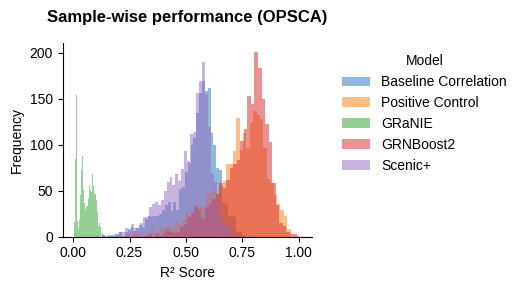

In [61]:
fig, ax = plt.subplots(figsize=(5.5, 3))
def plot_sample_wise_scores_distribution(scores_store_all_reg1, ax):
    # Get unique models and define colors
    models = scores_store_all_reg1['model'].unique()
    colors = plt.cm.tab10(range(len(models)))  # Use a colormap for unique colors

    # Plot histograms for each model
    for model, color in zip(models, colors):
        subset = scores_store_all_reg1[scores_store_all_reg1['model'] == model]
        ax.hist(subset['r2score'], bins=50, alpha=0.5, label=model, color=color, edgecolor=None)

    # Add legend and labels
    ax.set_xlabel("R² Score")
    ax.set_ylabel("Frequency")
    ax.legend(loc=(1.1, .3), title="Model", frameon=False)

    for side in ['right', 'top']:
        ax.spines[side].set_visible(False)

    plt.title('Sample-wise performance (OPSCA)', fontsize=12, fontweight='bold', pad=15)
plot_sample_wise_scores_distribution(scores_store_all_reg1, ax)
plt.tight_layout()

fig.savefig(f"{results_folder}/explanatory_analysis/figs/reg1_sample_wise_scores_dist.png", dpi=300, transparent=True, bbox_inches='tight')

plt.show()

### Consistency across donors

/vol/tmp/users/jnourisa/ipykernel_3482998/461951273.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


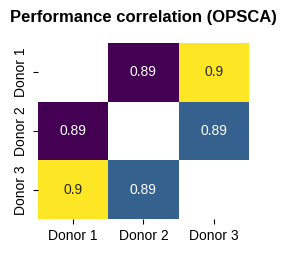

In [62]:

fig, ax = plt.subplots(1, 1, figsize=(3, 3), constrained_layout=True)
def plot_sample_wise_scores_similarity_donors(scores_store_all_reg1, ax):
    scores_store_table = scores_store_all_reg1.pivot_table(
        index='donor_id', 
        values='r2score', 
        columns=[col for col in scores_store_all_reg1.columns if col not in ['donor_id', 'r2score']]
    ).fillna(0)

    # Calculate the Spearman correlation matrix
    corr_matrix = scores_store_table.T.corr(method='spearman')

    np.fill_diagonal(corr_matrix.values, np.nan)
    # Plot heatmap on the appropriate subplot axis
    sns.heatmap(corr_matrix, annot=True, cmap="viridis", cbar=False, ax=ax)

    ax.set_xlabel("")
    ax.set_ylabel("")


    plt.title('Performance correlation (OPSCA)', fontsize=12, fontweight='bold', pad=15)
plot_sample_wise_scores_similarity_donors(scores_store_all_reg1, ax)
plt.tight_layout()

fig.savefig(f"{results_folder}/explanatory_analysis/figs/reg1_sample_wise_donor_corr.png", dpi=300, transparent=True, bbox_inches='tight')


### Similarity in performance across models

/vol/tmp/users/jnourisa/ipykernel_3482998/4042195805.py:20: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


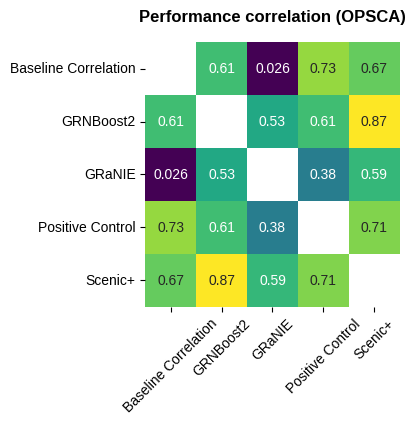

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), constrained_layout=True)
def plot_sample_wise_scores_similarity_models(scores_store_all_reg1, ax):
    scores_store_table = scores_store_all_reg1.pivot_table(
        index='model', 
        values='r2score', 
        columns=[col for col in scores_store_all_reg1.columns if col not in ['model', 'r2score']]
    ).fillna(0)

    spearman_corr = scores_store_table.T.corr(method='spearman')
    np.fill_diagonal(spearman_corr.values, np.nan)
    sns.heatmap(spearman_corr, annot=True, cmap="viridis", cbar=False, ax=ax)

    ax.set_xlabel("")
    ax.set_ylabel("")

    ax.tick_params(axis='x', rotation=45)

    plt.title('Performance correlation (OPSCA)', fontsize=12, fontweight='bold', pad=15)
plot_sample_wise_scores_similarity_models(scores_store_all_reg1, ax)
plt.tight_layout()

fig.savefig(f"{results_folder}/explanatory_analysis/figs/reg1_sample_wise_model_corr.png", dpi=300, transparent=True, bbox_inches='tight')


### Performance segregated by cell types


/vol/tmp/users/jnourisa/ipykernel_3482998/1711712597.py:4: UserWarning: The palette list has more values (7) than needed (4), which may not be intended.
  sns.boxplot(data=scores_store_all_reg1, x="model", y="r2score", hue="cell_type", ax=ax, showfliers=False, palette=colors_blind, boxprops={'edgecolor': 'none'} )


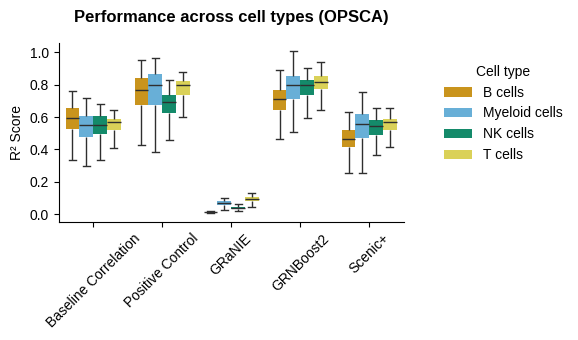

In [64]:

fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
def plot_sample_wise_scores_segregated_by_celltypes(scores_store_all_reg1, ax):

    sns.boxplot(data=scores_store_all_reg1, x="model", y="r2score", hue="cell_type", ax=ax, showfliers=False, palette=colors_blind, boxprops={'edgecolor': 'none'} )

    ax.set_ylabel("R² Score")
    ax.set_xlabel("")
    ax.legend(loc=(1.1, .3), title="Cell type", frameon=False)

    for side in ['right', 'top']:
        ax.spines[side].set_visible(False)

    plt.title('Performance across cell types (OPSCA)', fontsize=12, fontweight='bold', pad=15)
    ax.tick_params(axis='x', rotation=45)
plot_sample_wise_scores_segregated_by_celltypes(scores_store_all_reg1, ax)
plt.tight_layout()

fig.savefig(f"{results_folder}/explanatory_analysis/figs/reg1_sample_wise_cell_type.png", dpi=300, transparent=True, bbox_inches='tight')

plt.show()

### Performacne segragated by PC and NC samples

/vol/tmp/users/jnourisa/ipykernel_3482998/704490100.py:13: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.boxplot(data=scores_store_all_reg1, x="model", y="r2score", hue="controls", ax=ax, palette=sns.color_palette()[2:], boxprops={'edgecolor': 'none'}, showfliers=False)


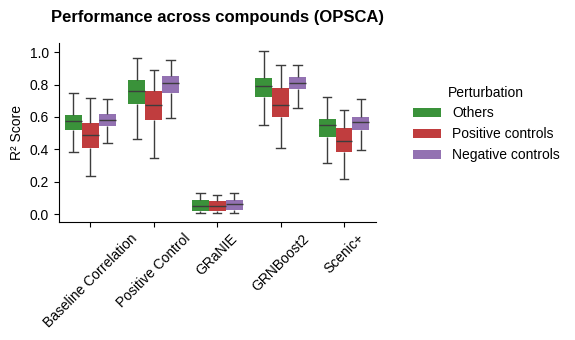

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
def plot_sample_wise_scores_segregated_by_controls(scores_store_all_reg1, ax):
    scores_store_all_reg1['controls'] = 'Others'
    mask_pc = scores_store_all_reg1.perturbation.isin(['Dabrafenib', 'Belinostat'])
    scores_store_all_reg1.loc[mask_pc, 'controls'] = 'Positive controls'
    mask_nc = scores_store_all_reg1.perturbation.isin(['Dimethyl Sulfoxide'])
    scores_store_all_reg1.loc[mask_nc, 'controls'] = 'Negative controls'

    scores_store_controls = scores_store_all_reg1[scores_store_all_reg1.perturbation.isin(controls3)]

    # - plot for all cell types

    sns.boxplot(data=scores_store_all_reg1, x="model", y="r2score", hue="controls", ax=ax, palette=sns.color_palette()[2:], boxprops={'edgecolor': 'none'}, showfliers=False)

    ax.set_ylabel("R² Score")
    ax.set_xlabel("")
    ax.legend(loc=(1.1, .3), title="Perturbation", frameon=False)

    for side in ['right', 'top']:
        ax.spines[side].set_visible(False)

    plt.title('Performance across compounds (OPSCA)', fontsize=12, fontweight='bold', pad=15)
    ax.tick_params(axis='x', rotation=45)
plot_sample_wise_scores_segregated_by_controls(scores_store_all_reg1, ax)
plt.tight_layout()

fig.savefig(f"{results_folder}/explanatory_analysis/figs/reg1_sample_wise_compounds.png", dpi=300, transparent=True, bbox_inches='tight')

plt.show()


### Joint distribution of sample wise scores

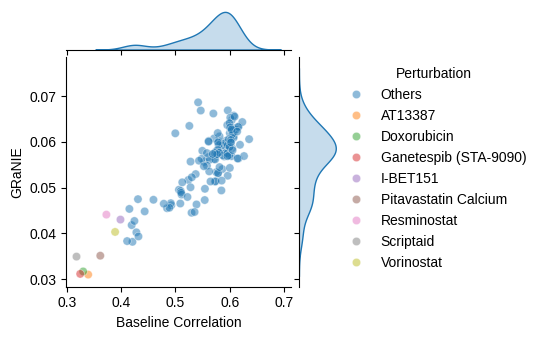

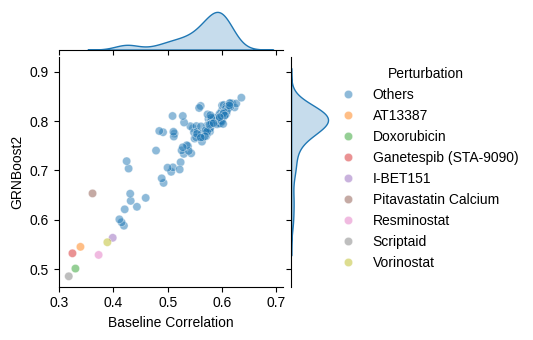

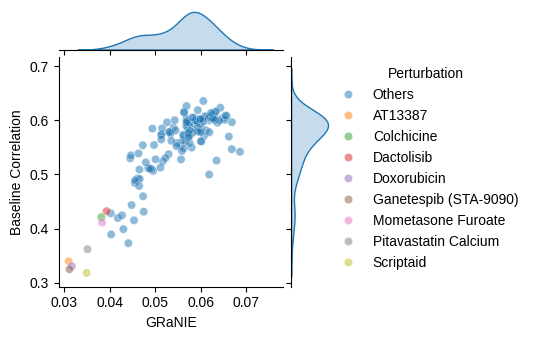

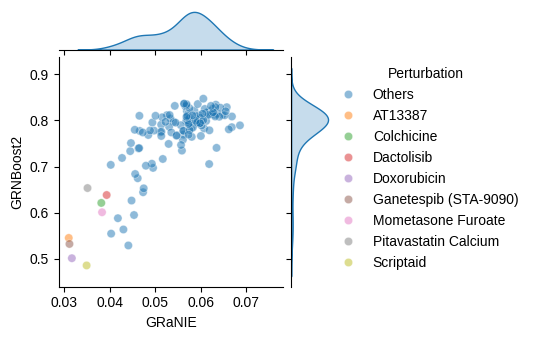

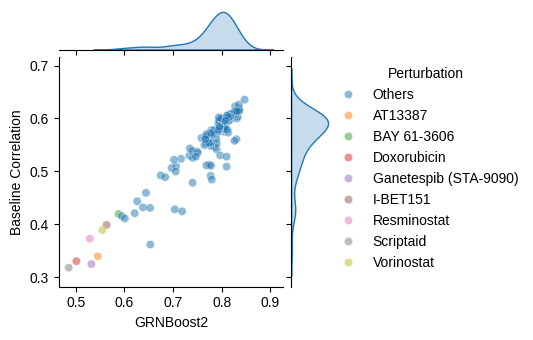

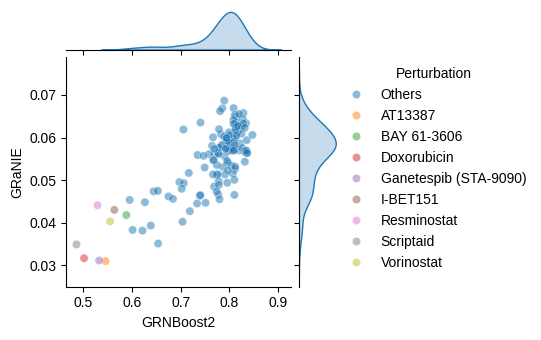

In [137]:
def plot_joint_sample_wise_scores(scores_store_all_reg1, x_name, y_name):
    if dataset == 'op':
        # Aggregate the data to handle duplicates
        subset_df_agg = scores_store_all_reg1.groupby(['perturbation', 'cell_type', 'model'], as_index=False)['r2score'].mean()
        pivot_df = subset_df_agg.pivot(index=['perturbation', 'cell_type'], columns='model', values='r2score')
    else:
        subset_df_agg = scores_store_all_reg1.groupby([perturb_col, 'model'], as_index=False)['r2score'].mean()
        pivot_df = subset_df_agg.pivot(index=[perturb_col], columns='model', values='r2score')
        pass
    pivot_df = pivot_df.reset_index()
    
    low_score_compounds = pivot_df[[perturb_col, x_name, y_name]].sort_values(by=[x_name, y_name]).head(8)
    low_score_mask = pivot_df[perturb_col].isin(low_score_compounds[perturb_col])
    low_scoring_samples = pivot_df[low_score_mask][perturb_col].unique()

    pivot_df['perturb_filter'] = 'Others'
    
    pivot_df.loc[low_score_mask, 'perturb_filter'] = pivot_df.loc[low_score_mask, perturb_col]

    sns.jointplot(
        data = pivot_df, 
        x = f"{x_name}", 
        y = f"{y_name}", 
        hue='perturb_filter',   # Color points by "True"/"False"
        # style='cell_type',
        # markers=True,
        # kind="kde",    # Contours with kde
        # fill=False,    # Fill contour lines
        marginal_kws=dict(common_norm=False, fill=True),  # Marginal distribution,
        height=3.5,
        alpha=.5
    )
    legend = plt.legend(bbox_to_anchor=(1.7, 1), loc='upper right', borderaxespad=0, frameon=False)

    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.legend(loc=(1.2, .05), title="Perturbation", frameon=False)
    # plt.legend(loc=(1.3, .2))
    return low_scoring_samples
low_scoring_samples_store = []
for i in range(3):
    for j in range(3):
        if i == j:
            continue

        name1 = surragate_names[par_reg1['grn_models'][i]]
        name2 = surragate_names[par_reg1['grn_models'][j]]

        low_scoring_samples = plot_joint_sample_wise_scores(scores_store_all_reg1, name1, name2)

        if (name1.lower()=='granie') | (name2.lower()=='granie'):
            pass
        else:
            low_scoring_samples_store.append(low_scoring_samples)
        # plt.suptitle('Performance across compounds (OPSCA)', fontsize=12, fontweight='bold', y=1.2)

        # plt.tight_layout()

        plt.savefig(f"{results_folder}/explanatory_analysis/figs/reg1_sample_wise_compounds_{name1}_{name2}.png", dpi=300, transparent=True, bbox_inches='tight')

        plt.show()


In [67]:
low_scoring_samples_intersect = np.intersect1d(low_scoring_samples_store[0], low_scoring_samples_store[1])
low_scoring_samples_intersect

array(['ABT-199 (GDC-0199)', 'Colchicine', 'Doxorubicin',
       'Ganetespib (STA-9090)', 'Tacalcitol'], dtype=object)

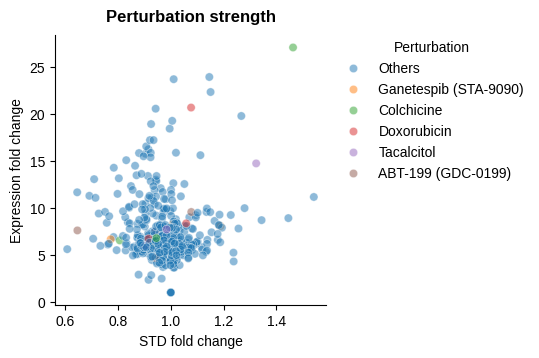

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5))

def plot_perturbation_strength_lowscored_samples(feature_importance_all_reg1, ax):

    low_scoring_samples = np.concatenate(low_scoring_samples_store)
    perturb_effect_all = pd.read_csv('../results_folder/perturb_effect_all.csv')
    perturb_effect_all = perturb_effect_all[perturb_effect_all['Dataset']=='op']
    low_score_mask = perturb_effect_all['perturbation'].isin(low_scoring_samples_intersect)

    perturb_effect_all['perturbation_subset'] = 'Others'
    perturb_effect_all.loc[low_score_mask, 'perturbation_subset'] = perturb_effect_all.loc[low_score_mask, 'perturbation']

    sns.scatterplot(perturb_effect_all, x='STD fold change', y='Expression fold change', hue='perturbation_subset', alpha=.5, ax=ax) 
    for side in ['right', 'top']:
        ax.spines[side].set_visible(False)
    ax.legend(bbox_to_anchor=(1.75, 1), loc='upper right', borderaxespad=0, frameon=False, title="Perturbation")
    ax.set_title(f"Perturbation strength", pad=10, fontsize=12, fontweight='bold')
plot_perturbation_strength_lowscored_samples(feature_importance_all_reg1, ax)

fig.savefig(f"{results_folder}/explanatory_analysis/figs/perturbation_strength_lowscored_compounds.png", dpi=300, transparent=True, bbox_inches='tight')

In [69]:
if False:
    fig, ax = plt.subplots(1, 1, figsize=(4,4))
    cmap = sns.color_palette("coolwarm", as_cmap=True)

    scores_store_sub = scores_store[scores_store['model']=='positive_control'][['perturbation','r2score']].rename(columns={'perturbation':'perturbation'})

    perturb_effect_all = perturb_effect_all.merge(scores_store_sub, on='perturbation')

    sns.scatterplot(perturb_effect_all, x='STD fold change', y='Expression fold change', hue='r2score', alpha=.5, ax=ax, palette=cmap)
    legend = ax.legend(bbox_to_anchor=(1.45, 1), loc='upper right', borderaxespad=0, frameon=False)
    legend.set_title("low_score") 

### Feature importance: similarity across models

/vol/tmp/users/jnourisa/ipykernel_3482998/2377685180.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


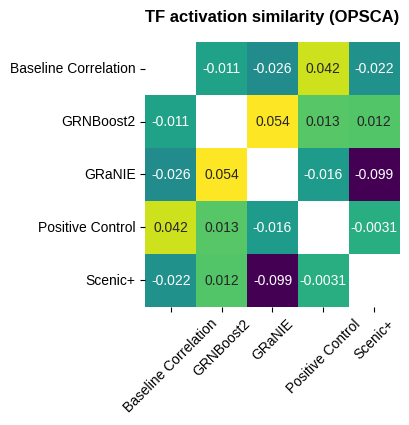

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), constrained_layout=True)

def plot_feature_importance_correlation_variation_across_models(feature_importance_all_reg1, ax):

    # - model specific feature importance -> only intersections 
    def lambda_func(df):
        return df['feature_importance'].values.flatten()

    df_pivot = feature_importance_all_reg1.groupby('model').apply(lambda_func)
    df_pivot = pd.DataFrame(df_pivot.tolist(), index=df_pivot.index)

    spearman_corr = df_pivot.T.corr(method='spearman')

    np.fill_diagonal(spearman_corr.values, np.nan)
    sns.heatmap(spearman_corr, annot=True, cmap="viridis", cbar=False, ax=ax)

    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)

    plt.title('TF activation similarity (OPSCA)', fontsize=12, fontweight='bold', pad=15)
plot_feature_importance_correlation_variation_across_models(feature_importance_all_reg1, ax)
plt.tight_layout()

fig.savefig(f"{results_folder}/explanatory_analysis/figs/reg1_feature_importannce_model_corr.png", dpi=300, transparent=True, bbox_inches='tight')

### Feature importance across donors

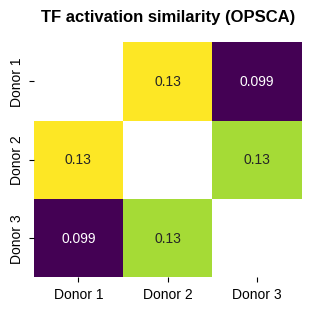

In [71]:
# - feature importance preservation across donors  -> only intersections 
fig, ax = plt.subplots(1, 1, figsize=(3, 3), constrained_layout=True)

def plot_feature_importance_correlation_variation_across_donors(feature_importance_all_reg1, ax):
    def lambda_func(df):
        return df['feature_importance'].values.flatten()

    # feature_importance
    df_pivot = feature_importance_all_reg1.groupby('donor_id').apply(lambda_func)
    df_pivot = pd.DataFrame(df_pivot.tolist(), index=df_pivot.index)

    # Calculate the Spearman correlation matrix
    corr_matrix = df_pivot.T.corr(method='spearman')

    np.fill_diagonal(corr_matrix.values, np.nan)
    # Plot heatmap on the appropriate subplot axis
    sns.heatmap(corr_matrix, annot=True, cmap="viridis", cbar=False, ax=ax)

    ax.set_xlabel("")
    ax.set_ylabel("")


    plt.title('TF activation similarity (OPSCA)', fontsize=12, fontweight='bold', pad=15)
plot_feature_importance_correlation_variation_across_donors(feature_importance_all_reg1, ax)
# plt.tight_layout()

fig.savefig(f"{results_folder}/explanatory_analysis/figs/reg1_feature_importannce_donor_corr.png", dpi=300, transparent=True, bbox_inches='tight')


In [72]:
if False:
    # Pivot with pivot_table and take the mean of duplicates
    if dataset in ['op']:
        columns = ['model', 'cell_type', perturb_col, 'donor_id']
    else:
        columns = ['model',  perturb_col]

    feature_importance_all_sub = feature_importance_all[feature_importance_all.model.isin(par_reg1['enrichment_models'])]
    feature_importance_common = feature_importance_all_sub.pivot_table(
        index=columns, 
        values='feature_importance', 
        columns='tf',
        aggfunc='mean'  # or 'sum', 'max', etc.
    )
    feature_importance_common = feature_importance_common.loc[:, ~feature_importance_common.isna().any(axis=0)]
    feature_importance_common.head()

    # - get the top features with highest sum across all models
    numeric_df = feature_importance_common.select_dtypes(include='number')
    mean_values_by_tf = numeric_df.groupby(level='tf', axis=1).mean()
    top_n_tfs = mean_values_by_tf.mean().nlargest(10).index
    print("Top 5 TFs with highest average values:")
    print(top_n_tfs)

    tf = 'DRAP1'
    df_one_tf = feature_importance_common[[tf]].reset_index()
    df_one_tf = df_one_tf[df_one_tf.perturbation.isin(controls3)]
    df_one_tf.perturbation = df_one_tf.perturbation.astype(str)

    sns.boxplot(data=df_one_tf, x="model", y=tf, hue="cell_type")
    plt.show()

    g = sns.catplot(
            data=df_one_tf, 
            x='model', 
            y=tf, 
            hue='cell_type', 
            col='perturbation', 
            kind='box',
            height=3, 
            # width=6, 
            aspect=1.4,
            # palette=colors_cell_type,
            legend_out=True
        )
    # Rotate the x-axis labels for all subplots
    for ax in g.axes.flatten():
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_xlabel('')
    # Adjust the position of the legend to the right
    g._legend.remove()
    g.add_legend(title="Cell type", bbox_to_anchor=(.95, 0.6), loc='center left')
    prefixes = ['(a)', '(b)', '(c)']
    for i, ax in enumerate(g.axes.flat):
        sub_title = ax.get_title().replace('perturbation = ', f'{prefixes[i]}: ').strip()  # Remove 'Type='
        ax.set_title(sub_title, pad=20, fontsize=12)

        ax.margins(x=0.05)

### Feature importance stability across control samples

/vol/tmp/users/jnourisa/ipykernel_3482998/2613230257.py:8: UserWarning: The palette list has more values (7) than needed (3), which may not be intended.
  ax = sns.boxplot(df, x='model', y='feature_importance', hue='perturbation', showfliers=False, palette=colors_blind, boxprops={'edgecolor': 'none'})


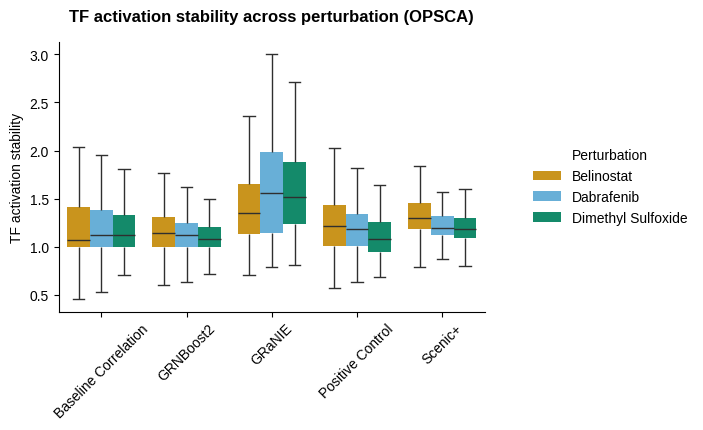

In [73]:

plt.figure(figsize=(5.5, 3.5))

def plot_feature_importance_variation_across_perturbation(feature_importance_all_reg1, ax):

    df = feature_importance_all_reg1[feature_importance_all_reg1['perturbation'].isin(controls3)]
    df = df.groupby(['perturbation','model'])[['tf', 'feature_importance']].apply(lambda df: df.groupby('tf').apply(lambda row: (np.mean(row)+1E-6)/(np.std(row)+1E-6))).reset_index()

    ax = sns.boxplot(df, x='model', y='feature_importance', hue='perturbation', showfliers=False, palette=colors_blind, boxprops={'edgecolor': 'none'})
    ax.set_ylabel('TF activation stability')

    ax.set_xlabel("")
    ax.legend(loc=(1.1, .3), title="Perturbation", frameon=False)

    for side in ['right', 'top']:
        ax.spines[side].set_visible(False)

    plt.title('TF activation stability across perturbation (OPSCA)', fontsize=12, fontweight='bold', pad=15)
    ax.tick_params(axis='x', rotation=45)

    # plt.tight_layout()

plot_feature_importance_variation_across_perturbation(feature_importance_all_reg1, ax)
fig.savefig(f"{results_folder}/explanatory_analysis/figs/reg1_feature_importance_stability.png", dpi=300, transparent=True, bbox_inches='tight')

plt.show()

# Stability analysis: Regression 2

In [108]:
dataset = 'op' #'nakatake' #op', norman


par_reg2 = {
    'grn_models': ['positive_control', 'pearson_corr', 'grnboost2', 'ppcor'],
    'best_performers': ['pearson_corr', 'positive_control', 'grnboost2'],
    'worse_performers': ['ppcor'],
    'grn_models_dir': f'{task_grn_inference_dir}/resources/grn_models/{dataset}/',
    'evaluation_data': f'{task_grn_inference_dir}/resources/evaluation_datasets/{dataset}_perturbation.h5ad',
    'layer': 'X_norm',
    'consensus':  f'../output/{dataset}_consensus-num-regulators.json',
    'tf_all': f'{task_grn_inference_dir}/resources/prior/tf_all.csv',
    'static_only': False,
    'num_workers': 4,
    'apply_tf': True,
    'apply_skeleton': False,
    'verbose': 2,
    'max_n_links': 50_000
}

exp_objs_dict = {}

for model in par_reg2['grn_models']:
    par_reg2['grn_model'] = f"{par_reg2['grn_models_dir']}/{model}.csv"
    if not os.path.exists(par_reg2['grn_model']):
        print(model, ' is skipped')
        continue
    net = pd.read_csv(par_reg2['grn_model'])

    print(model, len(net))
    obj = Exp_analysis(net)
    obj.calculate_basic_stats()
    exp_objs_dict[model] = obj


interaction_info = create_interaction_info(exp_objs_dict)
# fig = plot_interactions(interaction_info['target'], min_subset_size = 1, min_degree=1, color_map=None) 

positive_control 50000
pearson_corr 50000
grnboost2 50000
ppcor 50000


### Run the metric

In [109]:
# - imports 
sys.path.append('../../task_grn_inference/src/utils')
from task_grn_inference.src.metrics.regression_2.main import *
# - read inputs
tf_all = np.loadtxt(f'{task_grn_inference_dir}/resources/prior/tf_all.csv', dtype=str)

perturb_data = ad.read_h5ad(par_reg2['evaluation_data'])
gene_names = perturb_data.var_names
perturb_data

AnnData object with n_obs × n_vars = 2170 × 15215
    obs: 'cell_type', 'well', 'donor_id', 'row', 'perturbation', 'plate_name', 'cell_count', 'is_control', 'is_positive_control'
    layers: 'X_norm', 'counts', 'lognorm'

In [110]:
# - calculate the scores and feature importance 
if False:
    #- create consensuns
    from task_grn_inference.src.metrics.consensus.script import main
    par_reg2['models'] = par_reg2['grn_models']
    par_reg2['models_dir'] = par_reg2['grn_models_dir']
    main(par)

    if 'donor_id' not in perturb_data.obs:
        perturb_data.obs['donor_id'] = 'donor_one'
        perturb_data.obs['cell_type'] = 'cell_type'


    # - run reg
    scores_store = []

    i_iter = 0
    for reg_type in ['ridge']:
        for donor_id in perturb_data.obs.donor_id.unique():
            perturb_data_sub = perturb_data[perturb_data.obs.donor_id == donor_id]
            # perturb_data_sub = perturb_data_sub[:5, :] #TODO: remove this
            obs = perturb_data_sub.obs.reset_index(drop=True)

            for i_model, model in enumerate(par_reg2['grn_models']):
                net = pd.read_csv(f"{par_reg2['grn_models_dir']}/{model}.csv")
                
                net_matrix = net_to_matrix(net, gene_names, par)

                n_cells = perturb_data_sub.shape[0]
                random_groups = np.random.choice(range(1, 5+1), size=n_cells, replace=True) # random sampling
                groups = LabelEncoder().fit_transform(random_groups)

                # Load and standardize perturbation data
                layer = par_reg2['layer']
                if  layer=='X':
                    X = perturb_data_sub.X
                else:
                    X = perturb_data_sub.layers[layer]
                
                try:
                    X = X.todense().A
                except:
                    pass

                X = RobustScaler().fit_transform(X)

                # Load consensus numbers of putative regulators
                with open(par_reg2['consensus'], 'r') as f:
                    data = json.load(f)
                gene_names_ = np.asarray(list(data.keys()), dtype=object)
                n_features_dict = {gene_name: i for i, gene_name in enumerate(gene_names_)}

                n_features_theta_median = np.asarray([data[gene_name]['0.5'] for gene_name in gene_names], dtype=int)

                # Load list of putative TFs
                tf_names = np.loadtxt(par_reg2['tf_all'], dtype=str)
                if par_reg2['apply_tf']==False:
                    tf_names = gene_names

                rr_all = cross_validate(reg_type, gene_names, tf_names, X, groups, net_matrix, n_features_theta_median, n_jobs=par_reg2['num_workers'])

                r2_scores = np.asarray([rr_all['results'][j]['avg-r2'] for j in range(len(rr_all['results']))])
                mean_r2_scores = np.mean(r2_scores)

                print(mean_r2_scores)
                
                for i_gene, gene in enumerate(rr_all['gene_names']):
                    present = gene in net.target.unique()
                    r2score = rr_all['results'][i_gene]['avg-r2']
                    
                    reg_models = rr_all['results'][i_gene]['models']

                    # if False: # skip feature importance for now
                    if reg_type == 'ridge':
                        coeffs = [reg.coef_ for reg in reg_models]
                    else:
                        coeffs = [reg.get_feature_importance() for reg in reg_models]
                    coeffs = np.asarray(coeffs)
                    n_regulator = coeffs.shape[1]
                    


                    scores_store.append({
                        'reg_type': reg_type,
                        'donor_id':donor_id,
                        'r2score': r2score,
                        'present':present,
                        'model': model,
                        'gene': gene,
                        'n_regulator': n_regulator,
                        'n_present_regulators': net[net.target==gene]['source'].nunique(),
                        'feature_importance_mean2std': np.mean(np.abs(np.mean(coeffs, axis=0)+1E-6)/(np.std(coeffs, axis=0)+1E-6)).round(3)
                    })
                i_iter+=1
                
    scores_store = pd.DataFrame(scores_store)
    scores_store.to_csv(f'../results_folder/{dataset}_reg2_scores_store.csv')
    # feature_importance_all.to_csv('../results_folder/reg2_feature_importance.csv')

In [111]:
# - retreive regresion results
scores_store_all_reg2= pd.read_csv(f'../results_folder/{dataset}_reg2_scores_store.csv', index_col=0)
scores_store_all_reg2['feature_importance_mean2std_log'] = np.log1p(scores_store_all_reg2['feature_importance_mean2std'])

In [112]:
scores_store_all_reg2.model = scores_store_all_reg2.model.map(surragate_names)

scores_store_all_reg2['donor_id'] = scores_store_all_reg2['donor_id'].map({'donor_0':'Donor 1', 'donor_1':'Donor 2', 'donor_2':'Donor 3'})

scores_store_present = scores_store_all_reg2[scores_store_all_reg2['present']]


### Feature stability scores

/vol/tmp/users/jnourisa/ipykernel_3482998/3215153671.py:23: UserWarning: The palette list has more values (7) than needed (4), which may not be intended.
  sns.boxplot(data=scores_store_present, x='model', y='feature_importance_mean2std_log', ax=ax, palette=colors_blind, showfliers=False)


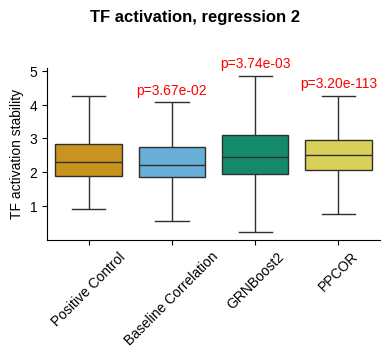

In [113]:
def plot_reg2_feature_stability_scores(scores_store_all_reg2, ax):
    from scipy.stats import mannwhitneyu

    scores_store_present = scores_store_all_reg2[scores_store_all_reg2['present']]
    df_common_pivot = scores_store_present.pivot(index=['model'], columns=['donor_id','gene'], values='feature_importance_mean2std').dropna(axis=1)
    common_genes = df_common_pivot.columns.get_level_values('gene').unique()

    df = df_common_pivot


    # Reference row
    ref = df_common_pivot.loc['Positive Control']

    # Perform Mann-Whitney U test for each row
    p_values = {}
    for row_name, row_data in df_common_pivot.iterrows():
        if row_name != 'Positive Control':
            stat, p_value = mannwhitneyu(row_data, ref, alternative='two-sided')
            p_values[row_name] = p_value

    # - stability changes 
    import seaborn as sns
    sns.boxplot(data=scores_store_present, x='model', y='feature_importance_mean2std_log', ax=ax, palette=colors_blind, showfliers=False)

    # # Annotate the p-values above the boxes
    i = 1
    positions = [4.2,5,4.4]
    for ii, row_name in enumerate(df_common_pivot.index):
        p_value = p_values.get(row_name, None)
        if p_value is not None:
            p_value = p_value*df_common_pivot.shape[0]
            ax.text(
                i,  # x-coordinate
                positions[ii],  # Position above the highest point in the box
                f"p={p_value:.2e}",  # Format p-value in scientific notation
                ha='center',
                va='bottom',
                fontsize=10,
                color='red'
            )
            i+=1

    ax.set_xlabel("")
    ax.set_ylabel("TF activation stability")

    for side in ['right', 'top']:
        ax.spines[side].set_visible(False)

    plt.suptitle('TF activation, regression 2', fontsize=12, fontweight='bold', y=1.01)
    ax.tick_params(axis='x', rotation=45)


fig, ax = plt.subplots(1, 1, figsize=(4, 3.5))
plot_reg2_feature_stability_scores(scores_store_all_reg2, ax)
plt.tight_layout()

fig.savefig(f"{results_folder}/explanatory_analysis/figs/reg2_feature_importance_stability.png", dpi=300, transparent=True, bbox_inches='tight')

plt.show()


### Number of regulators vs r2 scores and tf activation stability

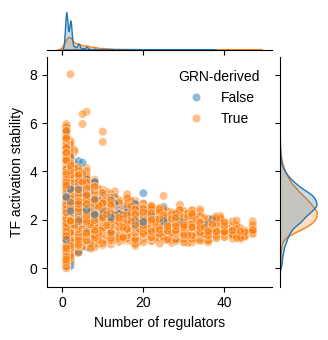

In [114]:
def plot_joint_reg2_tf_activation_vs_nregulators(scores_store_all_reg2):
    sns.jointplot(
            data = scores_store_all_reg2, 
            x = 'n_regulator', 
            y = 'feature_importance_mean2std_log', 
            hue= 'present',   # Color points by "True"/"False"
            # markers=True,
            # kind="kde",    # Contours with kde
            # fill=False,    # Fill contour lines
            marginal_kws=dict(common_norm=False, fill=True),  # Marginal distribution,
            alpha=.5,
            height=3.5
            # s=1
        )
    plt.legend(title="GRN-derived", frameon=False)
    plt.xlabel("Number of regulators")
    plt.ylabel("TF activation stability")
# plt.suptitle('Performance across compounds (OPSCA)', fontsize=12, fontweight='bold', y=1.2)
plot_joint_reg2_tf_activation_vs_nregulators(scores_store_all_reg2)
plt.savefig(f"{results_folder}/explanatory_analysis/figs/reg2_stability_vs_nregulators.png", dpi=300, transparent=True, bbox_inches='tight')

plt.show()

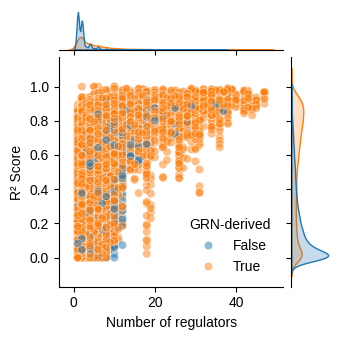

In [115]:
def plot_joint_reg2_r2scores_vs_nregulators(scores_store_all_reg2):

    sns.jointplot(
            data = scores_store_all_reg2, 
            x = 'n_regulator', 
            y = 'r2score', 
            hue= 'present',   
            # markers=True,
            # kind="kde",    
            # fill=False,    
            marginal_kws=dict(common_norm=False, fill=True),  # Marginal distribution,
            alpha=.5,
            height=3.5
            
        )
    plt.legend(title="GRN-derived", frameon=False)
    plt.xlabel("Number of regulators")
    plt.ylabel("R² Score")
# plt.suptitle('Performance across compounds (OPSCA)', fontsize=12, fontweight='bold', y=1.2)
plot_joint_reg2_r2scores_vs_nregulators(scores_store_all_reg2)
plt.savefig(f"{results_folder}/explanatory_analysis/figs/reg2_scores_vs_nregulators.png", dpi=300, transparent=True, bbox_inches='tight')

plt.show()

### Similary of scores across donors

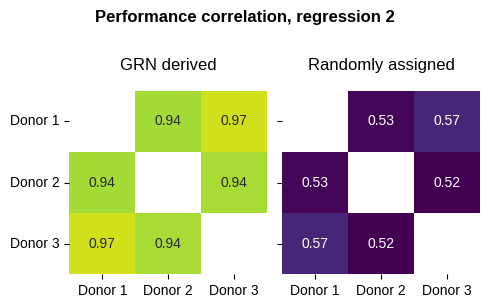

In [116]:
# Function to plot a heatmap with consistent color scaling
fig, axes = plt.subplots(1, 2, figsize=(5, 3), sharey=True)

def plot_reg2_perfromance_similarity_donors(scores_store_all_reg2):
    def plot_this_one(corr_matrix, ax, vmin, vmax):
        np.fill_diagonal(corr_matrix.values, np.nan)  # Optional: mask diagonal
        sns.heatmap(
            corr_matrix, 
            annot=True, 
            cmap="viridis", 
            cbar=False, 
            ax=ax, 
            vmin=vmin, 
            vmax=vmax
        )
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.tick_params('y', rotation=0)
    # Calculate correlation matrices for both conditions
    # GRN derived
    scores_store_table = scores_store_all_reg2[scores_store_all_reg2['present']][['donor_id', 'r2score', 'model', 'gene']].pivot(
        index='donor_id', 
        values='r2score', 
        columns=['model', 'gene']
    )
    corr_matrix_grn = scores_store_table.T.corr(method='spearman')

    # Randomly assigned
    scores_store_table = scores_store_all_reg2[~scores_store_all_reg2['present']][['donor_id', 'r2score', 'model', 'gene']].pivot(
        index='donor_id', 
        values='r2score', 
        columns=['model', 'gene']
    )
    corr_matrix_random = scores_store_table.T.corr(method='spearman')

    # Determine the global vmin and vmax for consistent color scale
    vmin = min(corr_matrix_grn.min().min(), corr_matrix_random.min().min())
    vmax = max(corr_matrix_grn.max().max(), corr_matrix_random.max().max())

    # Plot the heatmaps
    plot_this_one(corr_matrix_grn, axes[0], vmin, vmax)
    axes[0].set_title('GRN derived', pad=15)

    plot_this_one(corr_matrix_random, axes[1], vmin, vmax)
    axes[1].set_title('Randomly assigned', pad=15)

    # Set global title and save figure
    plt.suptitle('Performance correlation, regression 2', fontsize=12, fontweight='bold', y=1.01)
plot_reg2_perfromance_similarity_donors(scores_store_all_reg2)
plt.tight_layout()
fig.savefig(
    f"{results_folder}/explanatory_analysis/figs/reg2_scores_similarity_donors.png", 
    dpi=300, 
    transparent=True, 
    bbox_inches='tight'
)

### Similariy of scores across models

/vol/tmp/users/jnourisa/ipykernel_3482998/3602984854.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


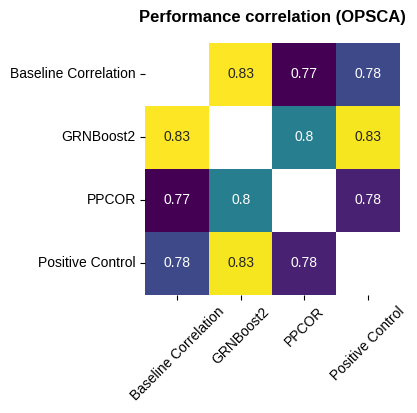

In [117]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), constrained_layout=True)
def plot_reg2_perfromance_similarity_models(scores_store_all_reg2, ax):


    scores_store_table = scores_store_all_reg2[['donor_id', 'r2score', 'model', 'gene']].pivot(
                index='model', 
                values='r2score', 
                columns=['donor_id', 'gene']
            )

    spearman_corr = scores_store_table.T.corr(method='spearman')
    np.fill_diagonal(spearman_corr.values, np.nan)
    sns.heatmap(spearman_corr, annot=True, cmap="viridis", cbar=False, ax=ax)

    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params('y', rotation=0)

    ax.tick_params(axis='x', rotation=45)

    plt.title('Performance correlation (OPSCA)', fontsize=12, fontweight='bold', pad=15)
plot_reg2_perfromance_similarity_models(scores_store_all_reg2, ax)
plt.tight_layout()

fig.savefig(f"{results_folder}/explanatory_analysis/figs/reg2_models_corr.png", dpi=300, transparent=True, bbox_inches='tight')


### Joint distribution of gene wise scores

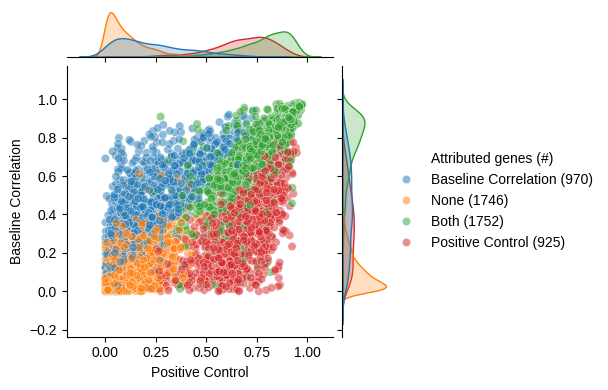

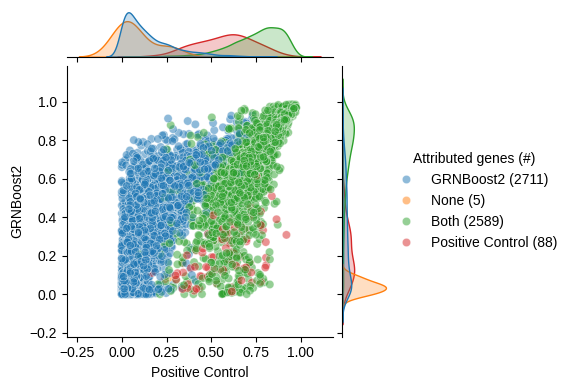

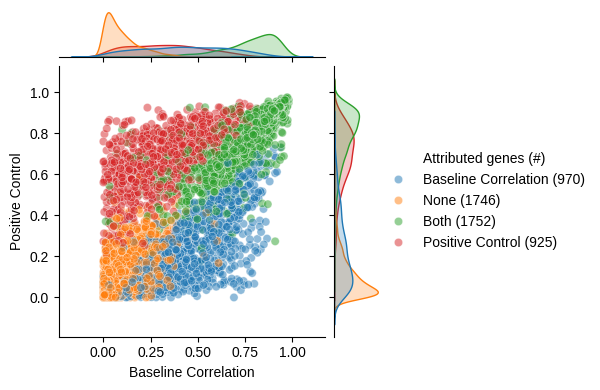

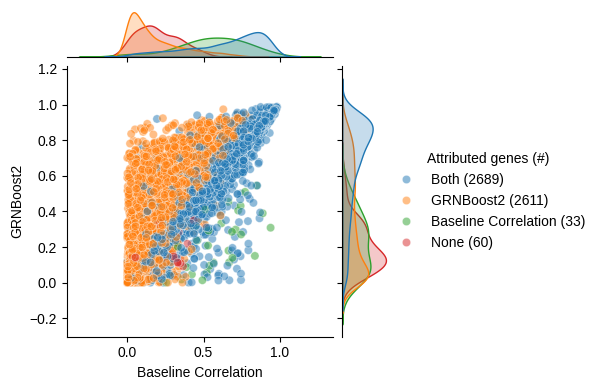

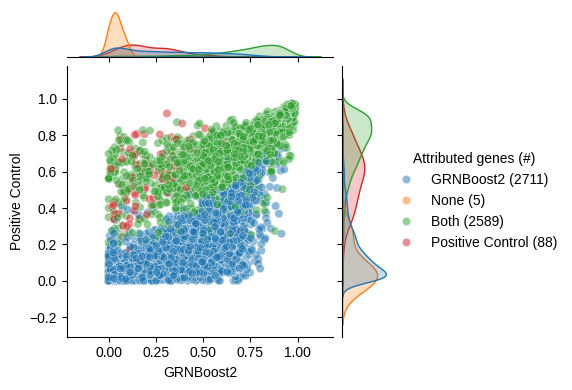

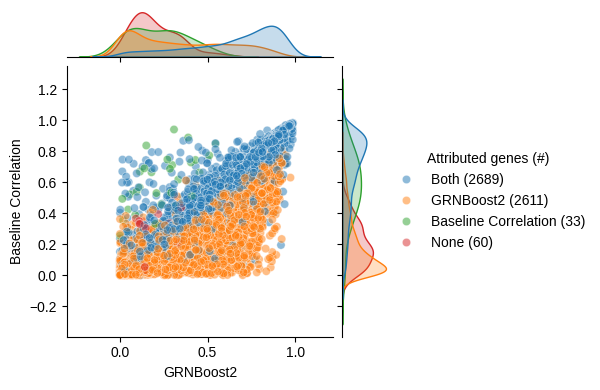

In [118]:
def plot_joint_gene_scores(method1, method2):
    
    scores_store_table = scores_store_all_reg2.pivot_table(index='gene', columns='model', values='r2score', aggfunc='mean')

    # - add common gene specs 
    present_table = scores_store_all_reg2.pivot_table(index='gene', columns='model', values='present', aggfunc='mean')
    present_table = present_table.astype(bool)

    scores_store_table['present'] = 'None'
    scores_store_table.loc[present_table[method1], 'present'] = method1
    scores_store_table.loc[present_table[method2], 'present'] = method2
    scores_store_table.loc[present_table[method1]&present_table[method2], 'present'] = 'Both'


    for name in ['None', method1, method2, 'Both']:
        mask = scores_store_table['present'] == name
        n = (mask).sum()
        scores_store_table.loc[mask, 'present'] += f' ({n})'

    sns.jointplot(
            data = scores_store_table, 
            x = method1, 
            y = method2, 
            hue= 'present',   # Color points by "True"/"False"
            # markers=True,
            # kind="kde",    # Contours with kde
            # fill=False,    # Fill contour lines
            marginal_kws=dict(common_norm=False, fill=True),  # Marginal distribution,
            alpha=.5,
            height=4
        )
    return scores_store_table
for i in range(3):
    for j in range(3):
        if i == j:
            continue

        name1 = surragate_names[par_reg2['grn_models'][i]]
        name2 = surragate_names[par_reg2['grn_models'][j]]
        scores_store_table = plot_joint_gene_scores(name1, name2)
        plt.legend(loc=(1.2, .3), title="Attributed genes (#)", frameon=False)

        # plt.suptitle('Performance across compounds (OPSCA)', fontsize=12, fontweight='bold', y=1.2)

        # plt.tight_layout()

        plt.savefig(f"{results_folder}/explanatory_analysis/figs/reg2_joint_r2scores_{name1}_{name2}.png", dpi=300, transparent=True, bbox_inches='tight')

        plt.show()

# Topological analysis

In [120]:
exp_objs_dict_dict = {}
for dataset in datasets:
# dataset = 'op' #'op', nakatake, adamson
    par_top_analysis = {
        
            'grn_models': ['negative_control', 'positive_control', 'pearson_corr', 'ppcor', 'portia', 'grnboost2', 'scenic', 'scglue', 'celloracle', 'figr', 'granie', 'scenicplus'],
            # 'grn_models': [ 'positive_control', 'pearson_corr', 'grnboost2', 'scenicplus', 'celloracle'],
            'shortlist': ['pearson_corr', 'ppcor', 'portia', 'grnboost2'],

            'peak_gene_models': ['celloracle', 'scenicplus', 'figr', 'granie'],
            'grn_models_dir': f'{task_grn_inference_dir}/resources/grn_models/{dataset}/',
            'peak_gene_dir': f'{task_grn_inference_dir}/resources/grn_models/{dataset}/peak_gene/',
    }

    exp_objs_dict = {}
    nets_dict = {}

    for model in par_top_analysis['grn_models']:
        par_top_analysis['grn_model'] = f"{par_top_analysis['grn_models_dir']}/{model}.csv"
        if not os.path.exists(par_top_analysis['grn_model']):
            print(model, ' is skipped')
            continue
        net = pd.read_csv(par_top_analysis['grn_model'])

        net = net.drop_duplicates()
        
        nets_dict[model] = net

        if model in par_top_analysis['peak_gene_models']:
            peak_gene_net = pd.read_csv(f"{par_top_analysis['peak_gene_dir']}/{model}.csv")
        else:
            peak_gene_net = None
        print(model, len(net))
        obj = Exp_analysis(net, peak_gene_net)
        obj.calculate_basic_stats()
        obj.calculate_centrality()

        exp_objs_dict[model] = obj
    exp_objs_dict = {surragate_names[key]:value for key,value in exp_objs_dict.items()}
    exp_objs_dict_dict[dataset] = exp_objs_dict

negative_control 50000
positive_control 50000
pearson_corr 50000
ppcor 50000
portia 50000
grnboost2 50000
scenic 64489
scglue 7227
celloracle 50000
figr 52962
granie 50000
scenicplus 41288
negative_control 50000
positive_control 50000
pearson_corr 50000
ppcor 50000
portia 50000
grnboost2 50000
scenic 18031
scglue  is skipped
celloracle  is skipped
figr  is skipped
granie  is skipped
scenicplus  is skipped
negative_control 50000
positive_control 50000
pearson_corr 50000
ppcor 50000
portia 50000
grnboost2 50000
scenic 99500
scglue  is skipped
celloracle  is skipped
figr  is skipped
granie  is skipped
scenicplus  is skipped
negative_control 28163
positive_control 50000
pearson_corr 50000
ppcor 50000
portia 50000
grnboost2 50000
scenic 2182
scglue  is skipped
celloracle  is skipped
figr  is skipped
granie  is skipped
scenicplus  is skipped
negative_control 50000
positive_control 50000
pearson_corr 50000
ppcor 50000
portia 50000
grnboost2 50000
scenic  is skipped
scglue  is skipped
cellorac

## General stats

In [121]:
for i, dataset in enumerate(datasets):
    exp_objs_dict = exp_objs_dict_dict[dataset]
    # regulatory links
    links_n = {}
    source_n = {}
    target_n = {}
    nets = {}

    for name, obj in exp_objs_dict.items():
        net = obj.net
        if 'cell_type' in net.columns: # for cell specific grn models, take the mean
            n_grn = net.groupby('cell_type').size().mean()
        else:
            n_grn = len(net)

        links_n[name] = n_grn
        source_n[name] = obj.stats['n_source']
        target_n[name] = obj.stats['n_target']
    # Prepare data for plotting
    data = {
        'Model': [],
        'Count': [],
        'Type': []
    }

    # Populate the data dictionary for each metric
    for model in links_n.keys():
        data['Model'].append(model)
        data['Count'].append(links_n[model])
        data['Type'].append('Putative links')

    for model in source_n.keys():
        data['Model'].append(model)
        data['Count'].append(source_n[model])
        data['Type'].append('Putative TFs')

    for model in target_n.keys():
        data['Model'].append(model)
        data['Count'].append(target_n[model])
        data['Type'].append('Putative target genes')

    # Create a DataFrame from the data dictionary
    df = pd.DataFrame(data)
    df['Dataset'] = dataset
    if i == 0:
        topology_stats =df
    else:
        topology_stats = pd.concat([topology_stats, df]).reset_index(drop=True)

In [122]:
topology_stats['Dataset'] = topology_stats['Dataset'].map(surragate_names)

/vol/tmp/users/jnourisa/ipykernel_3482998/725408243.py:2: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  g = sns.catplot(
/vol/tmp/users/jnourisa/ipykernel_3482998/725408243.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/vol/tmp/users/jnourisa/ipykernel_3482998/725408243.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/vol/tmp/users/jnourisa/ipykernel_3482998/725408243.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


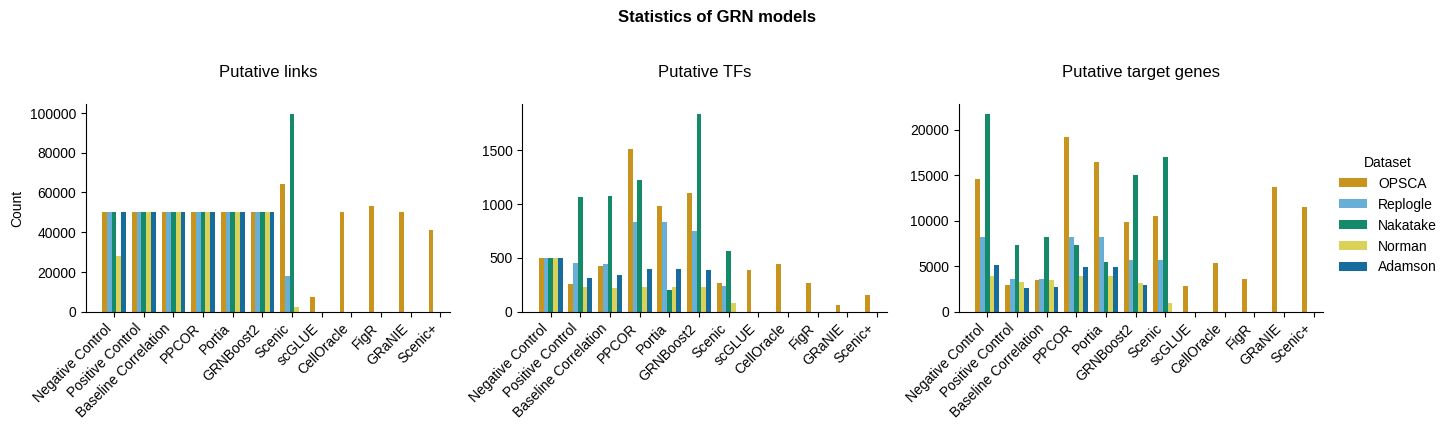

In [123]:
def plot_topology_stats():
    g = sns.catplot(
        data=topology_stats, 
        x='Model', 
        y='Count', 
        hue='Dataset', 
        col='Type', 
        kind='bar', 
        height=3, 
        aspect=1.5, 
        legend_out=True, 
        sharey=False,
        palette=colors_blind
    )
    for ax in g.axes.flatten():
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_xlabel('')
    prefixes = ['(a)', '(b)', '(c)']
    for i, ax in enumerate(g.axes.flat):
        sub_title = ax.get_title().split(' = ')[1]  # Remove 'Type='
        ax.set_title(sub_title, pad=20, fontsize=12)

        ax.margins(x=0.05)
    plt.suptitle('Statistics of GRN models', y=1.2,  fontsize=12, fontweight='bold')
plot_topology_stats()
plt.savefig(f"{results_folder}/explanatory_analysis/figs/grn_stats.png", dpi=300, transparent=True, bbox_inches='tight')

plt.show()

In [124]:
    # print(df)
    # aa

    # # Create the FacetGrid for separate y-axes
    # g = sns.FacetGrid(df, col='Type', height=3.5, aspect=1, sharey=False)

    # # Map the bar plot to each facet
    # g.map_dataframe(sns.barplot, x='Model', hue='Model', y='Count', palette=color_map_methods, alpha=0.9)

    # # Customize the plot
    # g.set_xticklabels(rotation=90)
    # g.set_axis_labels("", "Count")
    # # g.fig.suptitle("Gene Regulatory Network Statistics", y=1.05)

    # # Use ax.margins to set margins on the x-axis
    # for ax in g.axes.flat:
    #     ax.margins(x=0.05)  # Adjust the margin fraction as needed

    # # Remove the default titles and set custom titles without 'Type='
    # prefixes = ['(a)', '(b)', '(c)']
    # for i, ax in enumerate(g.axes.flat):
    #     title = ax.get_title().replace('Type = ', f'{prefixes[i]}: ').strip()  # Remove 'Type='
    #     ax.set_title(title, pad=20, fontsize=10, fontweight='bold')

    # # Remove spines for better aesthetics
    # for ax in g.axes.flat:
    #     ax.spines['right'].set_visible(False)
    #     ax.spines['top'].set_visible(False)
    # plt.suptitle(surragate_names[dataset], fontsize=12, fontweight='bold')
    # plt.tight_layout()
    # # plt.savefig(f'{results_folder}/explanatory_analysis/figs/stats_{dataset}.png', dpi=300, transparent=True)


## Network density 

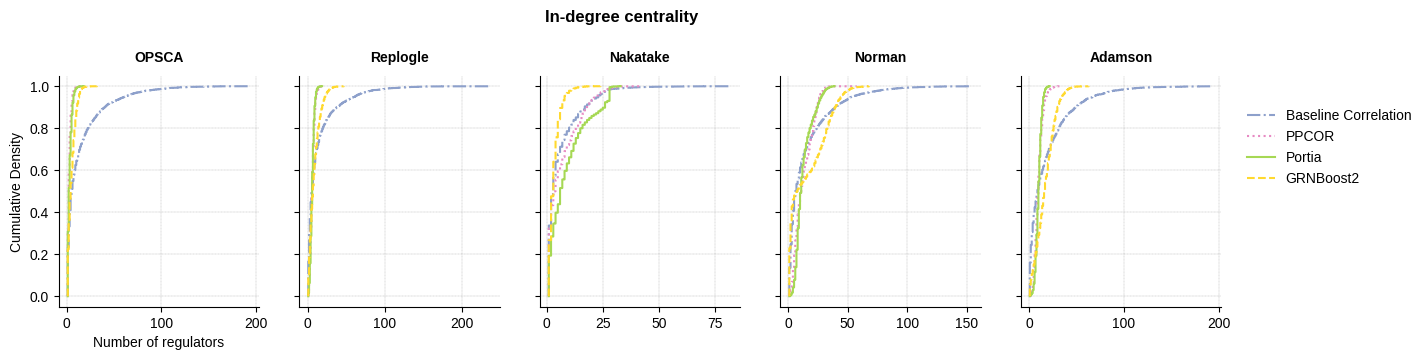

In [126]:
# tf gene: in degree

def plot_indegree_centrality():
    fig, axes = plt.subplots(1, 5, figsize=(15, 3), sharey=True)
    for i, dataset in enumerate(datasets):
        ax = axes[i]
        exp_objs_dict = exp_objs_dict_dict[dataset]
        for name in par_top_analysis['shortlist']:
            name = surragate_names.get(name,name)
            obj = exp_objs_dict[name]
            obj.calculate_centrality()
            values = obj.tf_gene.in_deg.degree.values

            obj.plot_cumulative_density(values, title='', x_label='Number of regulators', ax=ax, alpha=1, label=name, s=5, c=color_map_methods[name], linestyle=linestyle_map_methods[name])
            
            # ax.set_xlim([-5, 250])
            # ax.set_title('(a) In-degree centrality: TF-gene', pad=20)
        # plt.tight_layout()
        if i != 0:
            ax.set_ylabel('')
            ax.set_xlabel('')
        ax.set_title(surragate_names[dataset], pad=10, fontsize=10, fontweight='bold')

    ax.legend(frameon=False, loc=(1.1, .5))
    plt.suptitle('In-degree centrality', y=1.1, fontsize=12, fontweight='bold')
plot_indegree_centrality()
fig.savefig(f'{results_folder}/explanatory_analysis/figs/centrality_in.png', dpi=300, transparent=True,  bbox_inches='tight')

## Regulatory signs

In [127]:
if False:
    fig, axes = plt.subplots(1, len(datasets), figsize=(5*len(datasets), 4.5),   gridspec_kw={'width_ratios': [1.5, 1, 1, 1, 1]}  # Custom width ratios
    )
    for i, dataset in enumerate(datasets):
        ax = axes[i]
        exp_objs_dict = exp_objs_dict_dict[dataset]

        ratio_positive_negative_dict = {}

        for name, obj in exp_objs_dict.items():
            ratio_positive_negative_dict[name] = obj.stats['ratio_positive_negative']
        # ratio_positive_negative_dict[name] = obj.stats['ratio_positive_negative']

        data = ratio_positive_negative_dict
        models = list(data.keys())
        positive_r = [p for p in data.values()]
        negative_r = [1 - p for p in data.values()]


        df = pd.DataFrame({
            'Model': models * 2,  # Repeat model names for both Positive and Negative
            'Ratio': positive_r + negative_r,  # Concatenate positive and negative ratios
            'Regulatory Sign': ['Positive'] * len(models) + ['Negative'] * len(models)  # Label each as Positive or Negative
        })

        # Set Seaborn theme
        sns.set(style="whitegrid")  
        
        sns.barplot(x='Model', y='Ratio', hue='Regulatory Sign', data=df, width=.8,
                    palette=[list(color_map_methods.values())[1], list(color_map_methods.values())[0]], ax=ax)

        # Customize labels and ticks
        ax.set_ylabel('Ratio')
        ax.tick_params(axis='x', rotation=90)
        ax.margins(x=0.05)
        ax.set_xlabel('')
        ax.set_title(surragate_names[dataset], pad=20, fontsize=10, fontweight='bold')


        # Remove top and right spines
        sns.despine(ax=ax, top=True, right=True)

        ax.get_legend().remove()

        # Grid and legend
        # ax.grid(alpha=0.3, linestyle='--', linewidth=.5, color='grey')
        

    plt.suptitle('Regulatory sign', fontsize=12, fontweight='bold')
    plt.legend(frameon=False, loc=(1.1, .7))
    plt.tight_layout()
    # plt.savefig(f'{results_folder}/explanatory_analysis/figs/regulatory_signs.png', dpi=300, transparent=True)


## Interactions 

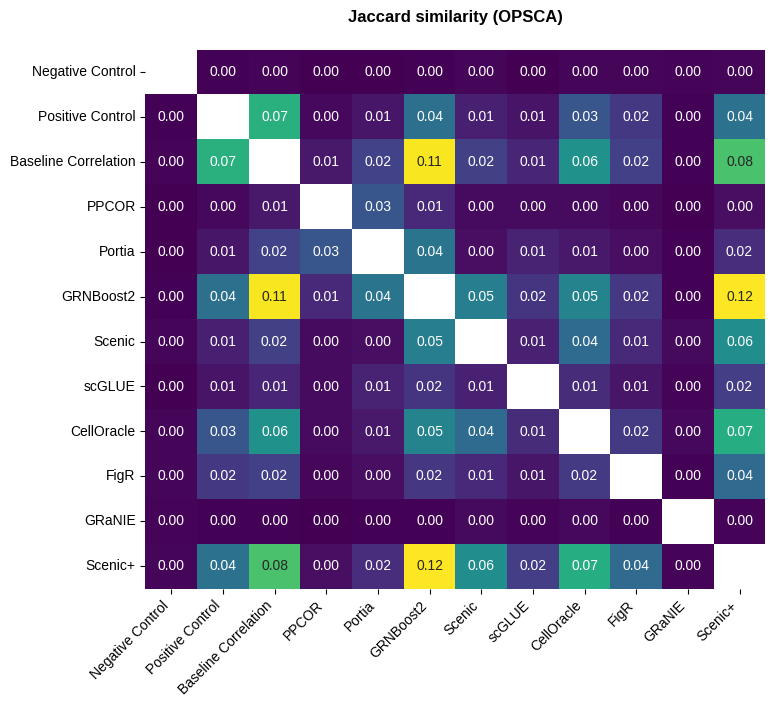

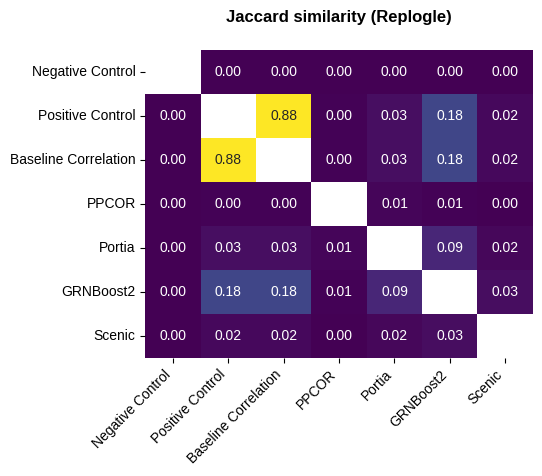

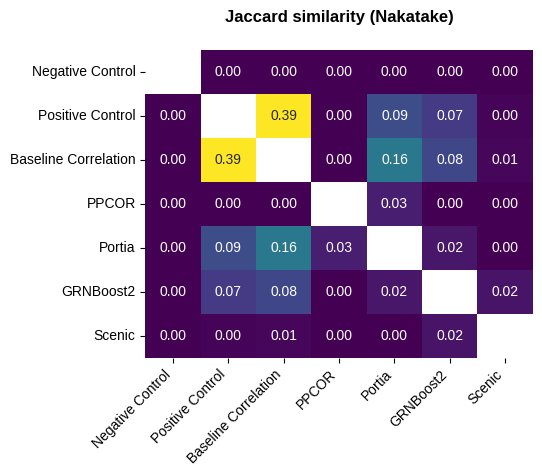

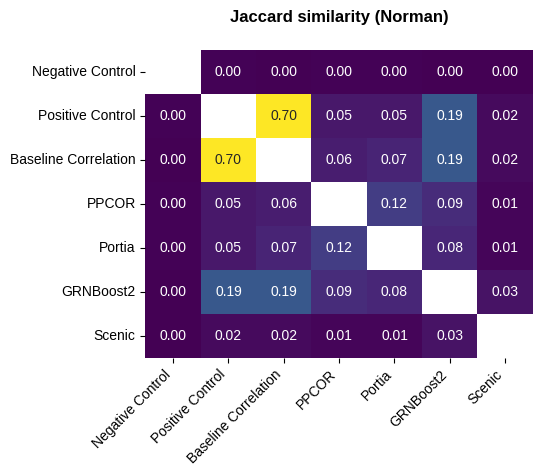

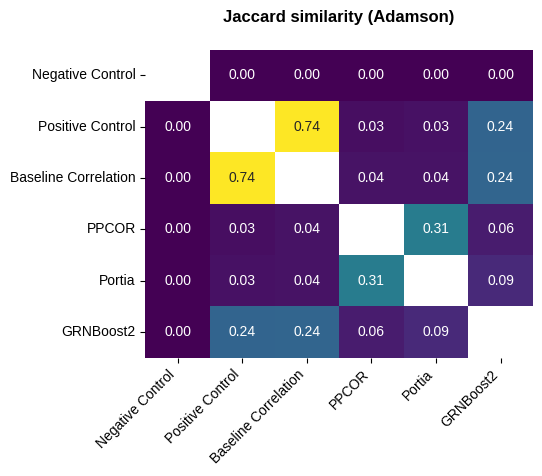

In [138]:
def plot_jaccard_similarity(dataset, ax):
    exp_objs_dict = exp_objs_dict_dict[dataset]
    nets = {}
    for name, obj in exp_objs_dict.items():
        nets[name] = obj.net
    _ = jaccard_similarity_net(nets, ax=ax)

    ax.set_title(f'Jaccard similarity ({surragate_names[dataset]})', pad=20, fontsize=12, fontweight='bold')
    

for i, dataset in enumerate(datasets):
    
    if dataset == 'op':
        figsize=(8, 7)
    else:
        figsize=(5, 4)
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    plot_jaccard_similarity(dataset, ax)
    plt.savefig(f'{results_folder}/explanatory_analysis/figs/jaccard_similarity_{dataset}.png', dpi=300, transparent=True, bbox_inches='tight')


In [129]:
if False:
    # Create a set of all unique genes
    for i, dataset in enumerate(datasets):
        ax = axes[i]
        exp_objs_dict = exp_objs_dict_dict[dataset]

        shortlist_grns =   [surragate_names[key] for key in par['shortlist']]
        interaction_info = create_interaction_info({key:exp_objs_dict[key] for key in shortlist_grns})
        # fig = plot_interactions(interaction_info['links'], min_subset_size = 1000, min_degree=3, color_map=None)    
        # fig.savefig(f'{results_folder}/explanatory_analysis/figs/links_interactions.png', dpi=300, transparent=True,  bbox_inches='tight')
        # fig = plot_interactions(interaction_info['source'], min_subset_size = 10, min_degree=2, color_map=None) 
        # fig.savefig(f'{results_folder}/explanatory_analysis/figs/TFs_interactions.png', dpi=300, transparent=True, bbox_inches='tight')
        fig = plot_interactions(interaction_info['target'], min_subset_size = 10, min_degree=2, color_map=None) 
        # fig.savefig(f'{results_folder}/explanatory_analysis/figs/targets_interactions.png', dpi=300, transparent=True, bbox_inches='tight')

# All plots

In [130]:
fig = plt.figure(figsize=(12, 12))

# Define the gridspec with uneven ratios for rows and columns
gs = fig.add_gridspec(3, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])

# Create subplots in each grid cell
ax1 = fig.add_subplot(gs[0, 0])  # Top-left grid (larger width)
ax2 = fig.add_subplot(gs[0, 1])  # Top-center grid
ax3 = fig.add_subplot(gs[0, 2])  # Top-right grid
ax4 = fig.add_subplot(gs[1, 0])  # Middle-left grid
ax5 = fig.add_subplot(gs[1, 1:])  # Middle-right grid, spanning two columns
ax6 = fig.add_subplot(gs[2, 0])  # Bottom-left grid
ax7 = fig.add_subplot(gs[2, 1])  # Bottom-center grid
ax8 = fig.add_subplot(gs[2, 2])  # Bottom-right grid

# Example plot for ax1
ax1.plot([1, 2, 3], [1, 4, 9])
ax1.set_title("Plot 1")

# Example plot for ax5 (spans two columns)
ax5.plot([1, 2, 3], [1, 4, 9])
ax5.set_title("Plot 5 (spanning two columns)")

# Show the layout
plt.tight_layout()
plt.show()


plot_perturbation_strength_datasets(perturb_effect_all, ax)
ax.set_title('(a)', weight='bold', pad=20)

plot_perturbation_strength_celltypes(perturb_effect_all, ax)

plot_consensus_number_of_regulators(dataset=dataset, axes # 3
)
plot_n_genes_with_regulators(n_genes_with_regulators_dict, ax)

plot_sample_wise_scores_distribution(scores_store_all_reg1, ax)

plot_sample_wise_scores_similarity_donors(scores_store_all_reg1, ax)

plot_sample_wise_scores_similarity_models(scores_store_all_reg1, ax)

plot_sample_wise_scores_segregated_by_celltypes(scores_store_all_reg1, ax)

plot_sample_wise_scores_segregated_by_controls(scores_store_all_reg1, ax)


plot_perturbation_strength_lowscored_samples(feature_importance_all_reg1, ax)

plot_feature_importance_correlation_variation_across_models(feature_importance_all_reg1, ax)

plot_feature_importance_correlation_variation_across_donors(feature_importance_all_reg1, ax)
def plot_feature_importance_variation_across_perturbation(feature_importance_all_reg1, ax)


SyntaxError: positional argument follows keyword argument (3054774376.py, line 11)

In [ ]:
plot_reg2_feature_stability_scores(scores_store_all_reg2, ax)
plot_joint_reg2_tf_activation_vs_nregulators(scores_store_all_reg2)
plot_joint_reg2_r2scores_vs_nregulators(scores_store_all_reg2)
plot_reg2_perfromance_similarity_donors(scores_store_all_reg2)
plot_reg2_perfromance_similarity_models(scores_store_all_reg2, ax)
plot_jaccard_similarity(dataset, ax)



In [ ]:
plot_joint_sample_wise_scores(scores_store_all_reg1, x_name, y_name)
plot_joint_gene_scores(method1, method2)
plot_topology_stats()
plot_indegree_centrality()

In [96]:
aaa

NameError: name 'aaa' is not defined

# CRE annoation

In [26]:
annotation_df = pd.read_csv(f'{task_grn_inference_dir}/resources/prior/peak_annotation.csv')
annotation_df.head()
for key, obj in exp_objs_dict.items():
    obj.annotate_peaks(annotation_df)

In [65]:
annotation_dict = {}
for name, obj in exp_objs_dict.items():
    if obj.peak_annot is not None:
        annotation_dict[name] = obj.peak_annot
peak_annotation_df = pd.DataFrame.from_dict(annotation_dict, orient='index')
threshold = 1 # remove below this raction
peak_annotation_df = peak_annotation_df.loc[:, (peak_annotation_df>threshold).sum(axis=0)!=0]
peak_annotation_df

,Promoter,Intron,Distal Intergenic,Exon,3' UTR,Downstream (<=300)
CellOracle,98.5,0.6,0.3,0.2,0.1,0.0
FigR,30.4,37.8,18.0,6.7,4.7,1.5
GRaNIE,66.2,15.8,10.4,4.0,2.3,0.9
Scenic+,35.1,34.4,17.3,6.8,4.4,1.2


In [115]:
peak_annotation_df = peak_annotation_df.reindex(['FigR', 'CellOracle', 'GRaNIE', 'Scenic+'])

/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_28270/1104589649.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if counts[j] == 0 or counts[j] < 4:  # Skip annotation for values less than 1%
/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_28270/1104589649.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(f'{counts[j]:.1f}%', xy=(x, y), xytext=(1.2*x, 1.2*y),


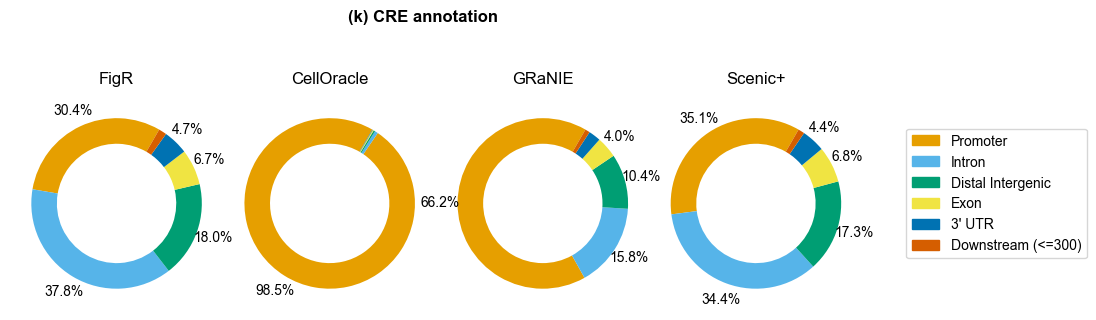

In [182]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np

# Create subplots with adjusted width ratios
fig, axes = plt.subplots(1, len(peak_annotation_df.index), figsize=(11, 4))
startangle = 60

# Iterate over pie charts
for i, (ax, idx) in enumerate(zip(axes, peak_annotation_df.index)):
    ax.set_title(idx, fontsize=12, pad=10)
    counts = peak_annotation_df.loc[idx]
    wedges, _ = ax.pie(counts, colors=colors_blind, wedgeprops=dict(width=0.3), startangle=startangle)

    for j, wedge in enumerate(wedges):
        if counts[j] == 0 or counts[j] < 4:  # Skip annotation for values less than 1%
            continue
        # Calculate angle and position for the annotation
        ang = (wedge.theta2 - wedge.theta1) / 2 + wedge.theta1
        x = np.cos(np.deg2rad(ang))
        y = np.sin(np.deg2rad(ang))
        ax.annotate(f'{counts[j]:.1f}%', xy=(x, y), xytext=(1.2*x, 1.2*y),
                    ha="center", va="center", fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", fc="none", ec="none"))

# Adjust spacing and add legend
plt.subplots_adjust(wspace=0)

# Create a single legend outside the pie charts
patches = [mpatches.Patch(color=color, label=name) for color, name in zip(colors_blind, peak_annotation_df.columns)]
fig.legend(handles=patches, loc='center right', bbox_to_anchor=(1.11, 0.52), fontsize=10)

fig.suptitle('(k) CRE annotation', fontsize=12, fontweight='bold')
# Save figure
fig.savefig(f'{results_folder}/explanatory_analysis/figs/peak_annotation.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()